# First version of AE with clustering loss

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
import h5py

2024-06-04 09:54:03.337431: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 09:54:04.173121: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 09:54:05.829219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 09:54:27.832994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [5]:
filename="./dataset/10X_PBMC.h5"
with h5py.File(filename, 'r') as f :
    data_X=f['X'][:]
    data_Y=f['Y'][:]
    df_X=pd.DataFrame(data_X)
    df_Y=pd.DataFrame(data_Y)
    
df_X

,0,1,2,3,4,5,6,7,8,9,...,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_Y.columns=['label']
df_Y["label"]=df_Y['label'].astype(str)
df_Y

,label
0,2
1,2
2,2
3,8
4,3
...,...
4266,6
4267,5
4268,7
4269,3


In [7]:
df_Y["label"].value_counts()

label
1    1292
2     702
3     606
4     459
5     450
6     332
7     295
8     135
Name: count, dtype: int64

In [8]:
data_ann=sc.AnnData(df_X)
data_ann

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4271 × 16653

In [9]:
data_ann.obs=df_Y

### Filter data

On filtre les données de manière peu stricte

In [10]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

/shared/home/tberthet/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
data_ann.raw = data_ann.copy()

In [12]:
data_ann

AnnData object with n_obs × n_vars = 4271 × 16653
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [13]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0
sc.pp.log1p(data_ann)


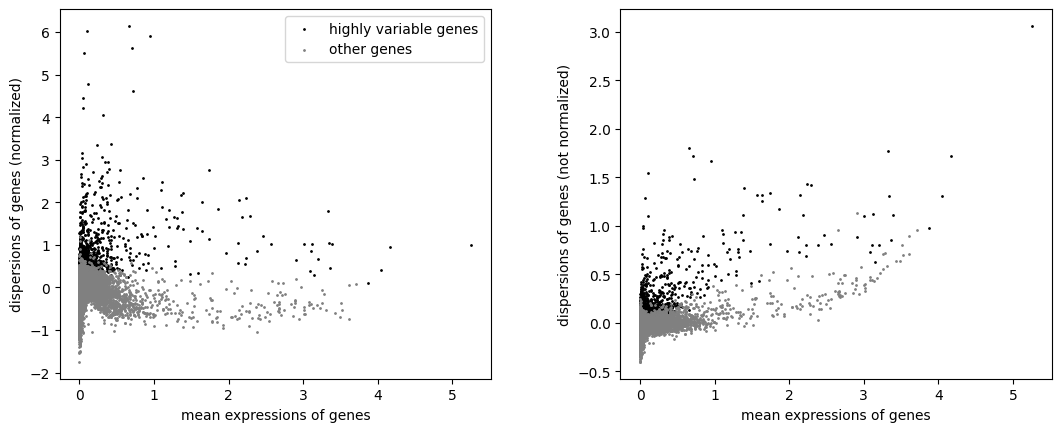

In [14]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [15]:
sc.pp.scale(data_ann)

### Explore the result

In [16]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [17]:
data_ann.n_vars

16653

In [18]:
data_ann.X

array([[-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       ...,
       [-0.04478425, -0.36973775, -0.22519336, ..., 16.46698363,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358],
       [-0.04478425, -0.36973775, -0.22519336, ..., -0.04429302,
        -0.05613264, -0.09001358]])

In [19]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
0,9,False,0.002611,-0.013101,-0.060134,0,False,0.001286,0.028724
1,570,False,0.135255,-0.001270,0.209814,1,False,0.091207,0.246681
2,225,False,0.050292,-0.021517,0.112911,1,False,0.034340,0.152490
3,12,False,0.001860,-0.149268,-0.466780,0,False,0.001729,0.033887
4,106,False,0.024858,0.030561,0.267766,1,False,0.016371,0.106600
...,...,...,...,...,...,...,...,...,...
16648,322,False,0.070651,0.029831,0.317225,2,False,0.050375,0.184955
16649,78,False,0.018880,0.000764,0.153966,2,False,0.011738,0.090542
16650,9,False,0.001481,-0.250185,-1.141559,0,False,0.001020,0.023021
16651,15,False,0.003912,-0.137269,-0.271806,0,False,0.002027,0.036117


In [20]:
data_ann.obs

,label,n_genes,size_factors
0,2,748,0.607636
1,2,1052,0.854590
2,2,739,0.600325
3,8,874,0.709992
4,3,951,0.772543
...,...,...,...
4266,6,1807,1.467912
4267,5,1249,1.014622
4268,7,2223,1.805849
4269,3,983,0.798538


In [21]:
data_ann.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.18050484,  2.43124879, -0.14809046, ...,  1.56127602,
         0.09961133, -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ...,  1.69599056,
         1.66225718, -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ...,  1.78981483,
         1.59504406, -0.09001358],
       ...,
       [-0.18050484,  1.1276868 , -0.14809046, ...,  0.37132976,
         0.64876498, -0.09001358],
       [-0.18050484,  1.59388979, -0.14809046, ..., -0.255126  ,
        -0.7171908 , -0.09001358],
       [-0.18050484, -0.53800062, -0.14809046, ..., -0.74846542,
         0.85199629, -0.09001358]])

In [23]:
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Create autoencoder

In [24]:
def negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    final = tf.reduce_mean(final)
    return final

def zero_inflated_negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2

    nb_case = t1 + t2 - tf.math.log(1.0-pi+eps)
    zero_nb = tf.pow(theta/(theta+mu+eps), theta)
    zero_case = -tf.math.log(pi + ((1.0-pi)*zero_nb)+eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    #ridge = self.ridge_lambda*tf.square(self.pi)
    #result += ridge
    result = tf.reduce_mean(result)
    return result

MeanAct = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.keras.backend.softplus(x), 1e-4, 1e4)

ColWiseMultLayer = lambda name: layers.Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))), name=name)

In [25]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters=n_clusters
        self.alpha=alpha
        self.intial_weights=weights
        #self.input_spec=keras.InputSpec(ndim=2) #to specify the expected rank of the input

    def build(self, input_shape):
        input_dim=input_shape[1]
        #self.input_spec=keras.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.intial_weights is not None :
            self.set_weights(self.intial_weights)
            del self.intial_weights
        self.built=True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.math.reduce_sum(tf.math.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.math.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [26]:
def create_autoencoder(input_shape, noise):
    init='glorot_uniform'
    Inputs = layers.Input(shape=(input_shape,), name='Inputs')
    sf_layer=layers.Input(shape=(1,), name="size_factors")
    x=layers.GaussianNoise(noise)(Inputs)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='encoder_1' )(x)
    x=layers.GaussianNoise(noise)(x)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='encoder_2' )(x)
    x=layers.GaussianNoise(noise)(x)
    hidden=layers.Dense(32, activation='relu',kernel_initializer=init, name='encoder_3' )(x)


    x=layers.Dense(32, activation='relu',kernel_initializer=init, name='decoder_1' )(hidden)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='decoder_2' )(x)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='decoder_3' )(x)
    pi=layers.Dense(input_shape, activation="sigmoid",kernel_initializer=init, name='pi')(x)
    disp=layers.Dense(input_shape, activation=DispAct,kernel_initializer=init, name='dispersion')(x)
    mean=layers.Dense(input_shape, activation=MeanAct,kernel_initializer=init, name='mean')(x)

    Outputs=ColWiseMultLayer(name='outputs')([mean, sf_layer])
    #Outputs=SliceLayer(0, name='slice')([Outputs, disp, pi])
    outputs = layers.Concatenate(axis=1, name='output')([Outputs, pi, disp])

    autoencoder=Model([Inputs, sf_layer], outputs, name='autoencoder_ZINB')
    autoencoder.compile(optimizer='adam', loss={'output': zero_inflated_negative_binomial_loss})

    autoencoder.summary()
    return autoencoder

In [27]:
input_shape=data_ann.n_vars
input_shape

16653

In [28]:
data_ann.X.shape[1]

16653

In [29]:
np.shape(data_ann.X)
data_ann

AnnData object with n_obs × n_vars = 4271 × 16653
    obs: 'label', 'n_genes', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'

On entraîne le modèle sur l'ensemble des données

In [30]:
def display_latent_space(y_pred, model, count_data_hvg , size_factors, obs):
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    encoder.summary()
    predict_data=encoder.predict([count_data_hvg, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    adata_latent.obs['predict']=y_pred
    anno=adata_latent.obs['label']
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    sc.pl.umap(adata_latent, color="label")
    sc.pl.umap(adata_latent, color="predict")
    crosstab = pd.crosstab(y_pred,anno)
    sns.heatmap(crosstab, annot=True, cmap='Blues')
    plt.ylabel('Clusters prédits')
    plt.xlabel('Annotations réelles')
    plt.title('Matrice de confusion')
    plt.show()

In [31]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    # Assurez-vous que les étiquettes sont de type str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # Trouver les étiquettes uniques
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Construire la matrice de coût (matrice de confusion)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    # Résoudre le problème de correspondance bipartite optimal
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Calculer la précision
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy

In [37]:
def save_results_to_csv(history, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, size_factors, y, y_pred, res, iteration, pdf_pages, train_test="train"):
    #Récupération des données et projection dans l'espace latent 
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    predict_data=encoder.predict([x, size_factors], verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Préparation des données pour Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    
    # Génération du UMAP avec Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_test}) (Res: {res}, Iter: {iteration})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_test}) (Res: {res}, Iter: {iteration})')
    

    pdf_pages.savefig(fig)
    plt.close(fig)

In [38]:
def target_distribution(q):
    weight = q**2/q.sum(0)
    return (weight.T/weight.sum(1)).T

def auto_kmeans(encoder, x_counts, size_factors, obs, plot=False):
    y=obs["label"]
    ari=[]
    nmi=[]
    x=[]
    for n in range (1,20):
        kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
        y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
        ari.append(adjusted_rand_score(y, y_pred))
        nmi.append(normalized_mutual_info_score(y, y_pred))
        x.append(n)
    somme_metriques = [x + y for x, y in zip(ari, nmi)]
    n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
    
    if plot==True:
        predict_data=encoder.predict([x_counts, size_factors])
        adata_latent = sc.AnnData(predict_data)
        adata_latent.obs=obs
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, size_factors, y, res="auto", plot=False):
    predict_data=encoder.predict([x_counts, size_factors], verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            x.append(i/10)
        somme_metriques = [x + y for x, y in zip(list_ari, list_nmi)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,list_nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        plt.plot()
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers
    
def split(x_counts, raw_counts, size_factors, y):
    train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)
    x_train=x_counts[train_idx]
    x_test=x_counts[test_idx]
    size_factors_train=size_factors[train_idx]
    size_factors_test=size_factors[test_idx]
    raw_train=raw_counts[train_idx]
    raw_test=raw_counts[test_idx]
    y_train=y[train_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test
    
def fit_and_split(x_counts, obs, size_factors, raw_counts, alpha, n_cluster="auto", res="auto", method="leiden", noise=0.5, batch_size=256,
        max_iter=2e4, tol=1e-3, update_interval=140, loss_weights=[1,1],
        ae_weights=None, pretrained=False):
    print('Update interval', update_interval)
    t0 = time.time()
    y=obs["label"]
    #step 0 split data
    x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test=split(x_counts, raw_counts, size_factors, y)
    input_shape=x_train.shape[1]
    #Step 1 Pretrain 
    if pretrained==False or ae_weights is None :
        print("..pretraining autoencoder : ")
        autoencoder=create_autoencoder(input_shape, noise)
        callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min', verbose=1)
        autoencoder.fit(x=[x_train, size_factors_train], y=raw_train, validation_data=([x_test,size_factors_test], raw_test), batch_size=batch_size, epochs=200, callbacks=[callback])
        autoencoder.save_weights("./model/weights/dif_pbmc_ae_res.weights.h5")
        ae_weights="./model/weights/dif_pbmc_ae_res.weights.h5"
    elif ae_weights is not None:
            autoencoder=create_autoencoder(input_shape, noise)
            autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')
    
    ae_layers = [l for l in autoencoder.layers]
    hidden = autoencoder.input[0]
    for i in range(1, len(ae_layers)):
        if "noise" in ae_layers[i].name:
            next
        elif "dropout" in ae_layers[i].name:
            next
        else:
            hidden = ae_layers[i](hidden)
        if "encoder_3" in ae_layers[i].name:  # only get encoder layers
             break
    encoder = Model(inputs=autoencoder.input, outputs=hidden, name='encoder')
    encoder.summary()

    
    #step 2 intialize clusters:
    
    #récupérons l'autoencoder
    #encoder= Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("hidden").output)
    if method=="leiden":
        print("Initializing cluster centers with leiden : ")
        res, y_pred, n_cluster, cluster_centers = auto_leiden(encoder, x_train, size_factors_train, y_train, res=res, plot=False)
        print('Le nombre de clusters est : ', n_cluster)
    elif method=="kmeans":
        print("Initializing cluster centers with k-means : ")
        if n_cluster=="auto":
            y_pred, n_cluster, cluster_centers=auto_kmeans(encoder, x_train, size_factors_train, obs, plot=False)
            print('Le nombre de clusters est : ', n_cluster)
        else :
            kmeans=KMeans(n_clusters=n_cluster, n_init=20)
            y_pred=kmeans.fit_predict(encoder.predict([x_train, size_factors]))
            cluster_centers=kmeans.cluster_centers_
        
    y_pred_last_train=np.copy(y_pred)
    
    clustering_layer = ClusteringLayer(n_cluster, alpha=alpha, name='clustering')(hidden)
    model= Model(inputs=[autoencoder.input[0], autoencoder.input[1]],
                           outputs=[clustering_layer, autoencoder.output])
    model.summary()
    model.compile(loss={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss}, optimizer='adam', metrics={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss})
    print("Set clustering weights")
    model.get_layer(name='clustering').set_weights([cluster_centers])
    print("Done")
    
    #step 3 deep clustering
    print("..Starting Deep Clustering")
    loss=[0,0,0]
    val_loss=[0,0,0]
    index=0
    save_interval = int(x_counts.shape[0] / batch_size) * 5 
    
    #Création du dictionnaire pour le monitoring
    history={
        "res":res,
        "clusters": n_cluster,
        "weight": loss_weights[0],
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[],
        "clustering_loss":[],
        "val_clustering_loss":[],
        "zinb_loss":[],
        "val_zinb_loss":[]
    }
        
    #initiate pdf files
    pdf_filename_train = 'data/res_test/plots/pbmc/plots_train_res_%.4f.pdf' % res
    #pdf_filename_train = check_existing_filename(pdf_filename_train)
    pdf_pages_train = PdfPages(pdf_filename_train)
    
    pdf_filename_test = 'data/res_test/plots/pbmc/plots_test_res_%.4f.pdf' % res
    #pdf_filename_test = check_existing_filename(pdf_filename_test)
    pdf_pages_test = PdfPages(pdf_filename_test)
    
    for iteration in range(int(max_iter)):
       
        #if iteration % update_interval==0:
        
        if index==0:
            q_train,_= model.predict([x_train, size_factors_train], verbose=0)
            p_train=target_distribution(q_train)
            q_test,_= model.predict([x_test, size_factors_test], verbose=0)
            p_test=target_distribution(q_test)
            
            loss=model.evaluate(x=[x_train, size_factors_train], y=[p_train, raw_train], batch_size=batch_size, verbose=0)
            val_loss=model.evaluate(x=[x_test, size_factors_test], y=[p_test, raw_test], batch_size=batch_size, verbose=0)
            
            y_pred_train=q_train.argmax(1)
            y_pred_test=q_test.argmax(1)
            if y is not None :
                ca=np.round(cluster_acc(y_train, y_pred_train), 5)
                nmi=np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
                ari=np.round(adjusted_rand_score(y_train, y_pred_train), 5)
                val_ca=np.round(cluster_acc(y_test, y_pred_test), 5)
                val_nmi=np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
                val_ari=np.round(adjusted_rand_score(y_test, y_pred_test), 5)
                print('Iter-%d: CA=%.4f, NMI= %.4f, ARI= %.4f; L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (iteration, ca, nmi, ari, loss[0], loss[1], loss[2]))
                print('CA=%.4f, val_NMI= %.4f, val_ARI= %.4f; val_L= %.5f, val_Lc= %.5f,  val_Lr= %.5f'
                          % (val_ca, val_nmi, val_ari, val_loss[0], val_loss[1], val_loss[2]))
                
                #maj du dictionnaire 
                history["CA"].append(ca)
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["val_CA"].append(val_ca)
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["loss"].append(loss[0])
                history["clustering_loss"].append(loss[1])
                history["zinb_loss"].append(loss[2])
                history["val_loss"].append(val_loss[0])
                history["val_clustering_loss"].append(val_loss[1])
                history["val_zinb_loss"].append(val_loss[2])
                
                if iteration==0:
                    history['CA_initial']=ca
                    history['ARI_initial']=ari
                    history['NMI_initial']=nmi
                    history['val_CA_initial']=val_ca
                    history['val_ARI_initial']=val_ari
                    history['val_NMI_initial']=val_nmi
                    
            
            #save a plot
            save_plot_umap(model, x_train, size_factors_train, y_train, y_pred_train, res, iteration, pdf_pages_train, "train")
            save_plot_umap(model, x_test, size_factors_test, y_test, y_pred_test, res, iteration, pdf_pages_test, "test")


                
            #stop criterion
            delta_label=np.sum(y_pred_train != y_pred_last_train).astype(np.float32)/y_pred_train.shape[0]
            y_pred_last_train=np.copy(y_pred_train)
            if iteration >0 and delta_label<tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
    
        if (index + 1)*batch_size > x_train.shape[0]:
            model.train_on_batch(x=[x_train[index * batch_size::], size_factors_train[index * batch_size:]],
                                                 y=[p_train[index * batch_size::], raw_train[index * batch_size::]])
            index=0
        else:
            model.train_on_batch(x=[x_train[index * batch_size:(index + 1) * batch_size], 
                                                    size_factors_train[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p_train[index * batch_size:(index + 1) * batch_size],
                                                    raw_train[index * batch_size:(index + 1) * batch_size]])
            index += 1
        
        #if iteration % save_interval == 0:
            # save scDeepCluster model checkpoints
            #print('saving model to: ''/weights' + str(iteration) + '.h5')
            #model.save_weights('/weights' + str(iteration) + '.h5')
            #print('saving model to: model/weights.weights.h5')
            #model.save_weights('model/weights.weights.h5')
    
        #iteration+=1
    
    ca = np.round(cluster_acc(y_train, y_pred_train), 5)
    nmi = np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
    ari = np.round(adjusted_rand_score(y_train, y_pred_train), 5)
    val_ca = np.round(cluster_acc(y_test, y_pred_test), 5)
    val_nmi = np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
    val_ari = np.round(adjusted_rand_score(y_test, y_pred_test), 5)
    print('Final: CA=%.4f, NMI= %.4f, ARI= %.4f' % (ca, nmi, ari))
    print('Final: val_CA=%.4f, val_NMI= %.4f, val_ARI= %.4f' % (val_ca, val_nmi, val_ari))
    duration=int(time.time() - t0)
    print('Clustering time: %d seconds.' % duration )
    history["training_time"]=duration
    history["nbr_iteration"]=iteration
    history['CA_final']=ca
    history['ARI_final']=ari
    history['NMI_final']=nmi
    history['val_CA_final']=val_ca
    history['val_ARI_final']=val_ari
    history['val_NMI_final']=val_nmi
                    
    
    #save dictionnary
    save_results_to_csv(history, 'data/res_test/results_pbmc_diff_AE_res_2.csv')
    
    pdf_pages_train.close()
    pdf_pages_test.close()
    
    return y_pred, model

In [40]:
for res in [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7]:
    for i in range(4):
        y_pred, model=fit_and_split(count_data_hvg, data_ann.obs,  data_ann.obs.size_factors, raw_count_hvg, method="leiden", res=res, alpha=1.0, noise=0.5, n_cluster="auto", batch_size=256,
             max_iter=2e3, tol=1e-3, update_interval=27, loss_weights=[1,1],
             pretrained=False)

Update interval 27
Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_25   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_26   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_27   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.6244 - val_loss: 0.3969
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3849 - val_loss: 0.3560
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3442 - val_loss: 0.3349
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3304 - val_loss: 0.3260
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3222 - val_loss: 0.3210
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3169 - val_loss: 0.3177
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3146 - val_loss: 0.3159
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3092 - val_loss: 0.3149
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3102 - val_loss: 0.3134
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3096 - val_loss: 0.3132
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3078 - val_loss: 0.3121
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  5


Model: "functional_443"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_25   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_26   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_27   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 5)         │        160 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,752 (7.98 MB)

 Trainable params: 2,092,752 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6976, NMI= 0.6973, ARI= 0.5351; L= 0.41252, Lc= 0.12071,  Lr= 0.29152
CA=0.6854, val_NMI= 0.6952, val_ARI= 0.5212; val_L= 0.42276, val_Lc= 0.11536,  val_Lr= 0.30293
Iter-14: CA=0.7102, NMI= 0.7146, ARI= 0.5759; L= 0.38250, Lc= 0.08685,  Lr= 0.29557
CA=0.7111, val_NMI= 0.7311, val_ARI= 0.5875; val_L= 0.40386, val_Lc= 0.09501,  val_Lr= 0.30432
Iter-28: CA=0.7140, NMI= 0.7230, ARI= 0.5966; L= 0.36001, Lc= 0.05948,  Lr= 0.29995
CA=0.7158, val_NMI= 0.7446, val_ARI= 0.6123; val_L= 0.39012, val_Lc= 0.07848,  val_Lr= 0.30741
Iter-42: CA=0.7149, NMI= 0.7257, ARI= 0.6075; L= 0.34509, Lc= 0.04343,  Lr= 0.30071
CA=0.7170, val_NMI= 0.7557, val_ARI= 0.6285; val_L= 0.38122, val_Lc= 0.07088,  val_Lr= 0.30682
Iter-56: CA=0.7163, NMI= 0.7282, ARI= 0.6132; L= 0.33688, Lc= 0.03443,  Lr= 0.30165
CA=0.7170, val_NMI= 0.7621, val_ARI= 0.6374; val_L= 0.37600, val_Lc= 0.06609,  val_Lr= 0.30632
Iter-70: CA=0.7181, NMI= 0.7330, ARI= 0.6190; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_28   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_29   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_30   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.6291 - val_loss: 0.3966
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3921 - val_loss: 0.3692
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3558 - val_loss: 0.3427
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3385 - val_loss: 0.3306
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3275 - val_loss: 0.3235
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3193 - val_loss: 0.3173
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3137 - val_loss: 0.3152
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3117 - val_loss: 0.3134
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3077 - val_loss: 0.3135
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3076 - val_loss: 0.3118
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3062 - val_loss: 0.3110
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  5


Model: "functional_485"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_28   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_29   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_30   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 5)         │        160 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,752 (7.98 MB)

 Trainable params: 2,092,752 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7020, NMI= 0.7030, ARI= 0.5502; L= 0.42102, Lc= 0.13212,  Lr= 0.28873
CA=0.6936, val_NMI= 0.7042, val_ARI= 0.5453; val_L= 0.43422, val_Lc= 0.12600,  val_Lr= 0.30339
Iter-14: CA=0.7119, NMI= 0.7216, ARI= 0.5891; L= 0.38854, Lc= 0.09607,  Lr= 0.29244
CA=0.7076, val_NMI= 0.7301, val_ARI= 0.5983; val_L= 0.40740, val_Lc= 0.09929,  val_Lr= 0.30266
Iter-28: CA=0.7163, NMI= 0.7343, ARI= 0.6142; L= 0.36152, Lc= 0.06407,  Lr= 0.29693
CA=0.7146, val_NMI= 0.7552, val_ARI= 0.6309; val_L= 0.38966, val_Lc= 0.07940,  val_Lr= 0.30533
Iter-42: CA=0.7166, NMI= 0.7328, ARI= 0.6256; L= 0.35273, Lc= 0.04959,  Lr= 0.30240
CA=0.7170, val_NMI= 0.7769, val_ARI= 0.6556; val_L= 0.38663, val_Lc= 0.07260,  val_Lr= 0.30954
Iter-56: CA=0.7172, NMI= 0.7322, ARI= 0.6314; L= 0.34608, Lc= 0.04353,  Lr= 0.30191
CA=0.7170, val_NMI= 0.7819, val_ARI= 0.6597; val_L= 0.37600, val_Lc= 0.06575,  val_Lr= 0.30639
Iter-70: CA=0.7181, NMI= 0.7346, ARI= 0.6376; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_31   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_32   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_33   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.5967 - val_loss: 0.3804
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3744 - val_loss: 0.3492
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3429 - val_loss: 0.3359
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3307 - val_loss: 0.3255
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3219 - val_loss: 0.3191
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3168 - val_loss: 0.3172
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3136 - val_loss: 0.3152
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3113 - val_loss: 0.3148
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3087 - val_loss: 0.3136
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3080 - val_loss: 0.3122
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3075 - val_loss: 0.3115
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  5


Model: "functional_527"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_31   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_32   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_33   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 5)         │        160 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,752 (7.98 MB)

 Trainable params: 2,092,752 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7017, NMI= 0.7022, ARI= 0.5483; L= 0.42281, Lc= 0.13322,  Lr= 0.28930
CA=0.6877, val_NMI= 0.6957, val_ARI= 0.5240; val_L= 0.43669, val_Lc= 0.12840,  val_Lr= 0.30341
Iter-14: CA=0.7114, NMI= 0.7167, ARI= 0.5832; L= 0.40081, Lc= 0.10747,  Lr= 0.29336
CA=0.7064, val_NMI= 0.7220, val_ARI= 0.5826; val_L= 0.41938, val_Lc= 0.10971,  val_Lr= 0.30356
Iter-28: CA=0.7163, NMI= 0.7268, ARI= 0.6131; L= 0.37371, Lc= 0.07711,  Lr= 0.29598
CA=0.7146, val_NMI= 0.7403, val_ARI= 0.6247; val_L= 0.40196, val_Lc= 0.09128,  val_Lr= 0.30407
Iter-42: CA=0.7231, NMI= 0.7363, ARI= 0.6299; L= 0.36166, Lc= 0.05821,  Lr= 0.30236
CA=0.7287, val_NMI= 0.7623, val_ARI= 0.6521; val_L= 0.40063, val_Lc= 0.08454,  val_Lr= 0.30948
Iter-56: CA=0.7254, NMI= 0.7387, ARI= 0.6381; L= 0.34736, Lc= 0.04478,  Lr= 0.30135
CA=0.7287, val_NMI= 0.7654, val_ARI= 0.6587; val_L= 0.38769, val_Lc= 0.07555,  val_Lr= 0.30648
Iter-70: CA=0.7257, NMI= 0.7393, ARI= 0.6425; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_34   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_35   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_36   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.6142 - val_loss: 0.3903
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3803 - val_loss: 0.3562
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3438 - val_loss: 0.3363
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3328 - val_loss: 0.3283
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3244 - val_loss: 0.3228
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3192 - val_loss: 0.3183
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3152 - val_loss: 0.3162
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3121 - val_loss: 0.3145
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3084 - val_loss: 0.3137
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3083 - val_loss: 0.3132
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3073 - val_loss: 0.3122
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  5


Model: "functional_569"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_34   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_35   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_36   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 5)         │        160 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,752 (7.98 MB)

 Trainable params: 2,092,752 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6923, NMI= 0.6902, ARI= 0.5271; L= 0.41349, Lc= 0.12210,  Lr= 0.29117
CA=0.6784, val_NMI= 0.6852, val_ARI= 0.5104; val_L= 0.42462, val_Lc= 0.11510,  val_Lr= 0.30457
Iter-14: CA=0.7117, NMI= 0.7194, ARI= 0.5828; L= 0.38978, Lc= 0.09478,  Lr= 0.29504
CA=0.7053, val_NMI= 0.7276, val_ARI= 0.5874; val_L= 0.41084, val_Lc= 0.10094,  val_Lr= 0.30479
Iter-28: CA=0.7157, NMI= 0.7281, ARI= 0.6090; L= 0.36840, Lc= 0.06991,  Lr= 0.29823
CA=0.7135, val_NMI= 0.7480, val_ARI= 0.6195; val_L= 0.39728, val_Lc= 0.08714,  val_Lr= 0.30613
Iter-42: CA=0.7163, NMI= 0.7343, ARI= 0.6223; L= 0.35466, Lc= 0.05503,  Lr= 0.29900
CA=0.7181, val_NMI= 0.7747, val_ARI= 0.6512; val_L= 0.38294, val_Lc= 0.07490,  val_Lr= 0.30502
Iter-56: CA=0.7169, NMI= 0.7365, ARI= 0.6285; L= 0.34473, Lc= 0.04274,  Lr= 0.30174
CA=0.7170, val_NMI= 0.7775, val_ARI= 0.6546; val_L= 0.38168, val_Lc= 0.07078,  val_Lr= 0.30763
Iter-70: CA=0.7166, NMI= 0.7349, ARI= 0.6322; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_37   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_38   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_39   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6093 - val_loss: 0.3891
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3831 - val_loss: 0.3625
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3501 - val_loss: 0.3385
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3350 - val_loss: 0.3291
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3265 - val_loss: 0.3225
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3209 - val_loss: 0.3183
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3147 - val_loss: 0.3166
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3132 - val_loss: 0.3146
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3083 - val_loss: 0.3134
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3083 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3079 - val_loss: 0.3116
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  5


Model: "functional_607"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_37   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_38   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_39   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 5)         │        160 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,752 (7.98 MB)

 Trainable params: 2,092,752 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7155, NMI= 0.7407, ARI= 0.6447; L= 0.42749, Lc= 0.13779,  Lr= 0.28933
CA=0.7158, val_NMI= 0.7781, val_ARI= 0.6621; val_L= 0.43912, val_Lc= 0.13220,  val_Lr= 0.30289
Iter-14: CA=0.7160, NMI= 0.7420, ARI= 0.6545; L= 0.40223, Lc= 0.10566,  Lr= 0.29641
CA=0.7146, val_NMI= 0.7551, val_ARI= 0.6556; val_L= 0.42175, val_Lc= 0.10945,  val_Lr= 0.30776
Iter-28: CA=0.7163, NMI= 0.7410, ARI= 0.6573; L= 0.37062, Lc= 0.07397,  Lr= 0.29624
CA=0.7135, val_NMI= 0.7492, val_ARI= 0.6539; val_L= 0.39614, val_Lc= 0.08863,  val_Lr= 0.30386
Iter-42: CA=0.7187, NMI= 0.7383, ARI= 0.6584; L= 0.36011, Lc= 0.06014,  Lr= 0.29922
CA=0.7158, val_NMI= 0.7547, val_ARI= 0.6601; val_L= 0.39226, val_Lc= 0.08265,  val_Lr= 0.30536
Iter-56: CA=0.7216, NMI= 0.7361, ARI= 0.6590; L= 0.36245, Lc= 0.05569,  Lr= 0.30580
CA=0.7216, val_NMI= 0.7523, val_ARI= 0.6604; val_L= 0.40163, val_Lc= 0.08484,  val_Lr= 0.31136
Iter-70: CA=0.7239, NMI= 0.7362, ARI= 0.6616; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_40   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_41   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_42   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6478 - val_loss: 0.3928
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3915 - val_loss: 0.3672
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3540 - val_loss: 0.3383
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3328 - val_loss: 0.3272
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3256 - val_loss: 0.3218
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3197 - val_loss: 0.3175
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3139 - val_loss: 0.3146
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3113 - val_loss: 0.3134
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3084 - val_loss: 0.3139
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3076 - val_loss: 0.3130
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3066 - val_loss: 0.3110
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_641"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_40   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_41   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_42   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7234, NMI= 0.7314, ARI= 0.6505; L= 0.44053, Lc= 0.15169,  Lr= 0.28837
CA=0.7170, val_NMI= 0.7611, val_ARI= 0.6566; val_L= 0.45067, val_Lc= 0.14253,  val_Lr= 0.30360
Iter-14: CA=0.7254, NMI= 0.7328, ARI= 0.6624; L= 0.40584, Lc= 0.11394,  Lr= 0.29175
CA=0.7111, val_NMI= 0.7427, val_ARI= 0.6540; val_L= 0.42400, val_Lc= 0.11724,  val_Lr= 0.30286
Iter-28: CA=0.7263, NMI= 0.7329, ARI= 0.6686; L= 0.38387, Lc= 0.08497,  Lr= 0.29842
CA=0.7099, val_NMI= 0.7367, val_ARI= 0.6612; val_L= 0.41576, val_Lc= 0.10341,  val_Lr= 0.30852
Iter-42: CA=0.7272, NMI= 0.7336, ARI= 0.6732; L= 0.36449, Lc= 0.06687,  Lr= 0.29700
CA=0.7099, val_NMI= 0.7395, val_ARI= 0.6699; val_L= 0.39986, val_Lc= 0.09169,  val_Lr= 0.30430
Iter-56: CA=0.7260, NMI= 0.7318, ARI= 0.6754; L= 0.35629, Lc= 0.05672,  Lr= 0.29942
CA=0.7135, val_NMI= 0.7470, val_ARI= 0.6809; val_L= 0.39781, val_Lc= 0.08864,  val_Lr= 0.30562
Iter-70: CA=0.7263, NMI= 0.7318, ARI= 0.6794; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_43   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_44   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_45   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.6383 - val_loss: 0.3877
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3864 - val_loss: 0.3642
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3544 - val_loss: 0.3429
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3353 - val_loss: 0.3305
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3250 - val_loss: 0.3237
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3198 - val_loss: 0.3186
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3139 - val_loss: 0.3167
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3127 - val_loss: 0.3149
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3092 - val_loss: 0.3154
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3100 - val_loss: 0.3128
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3070 - val_loss: 0.3119
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_687"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_43   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_44   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_45   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7526, NMI= 0.7527, ARI= 0.7004; L= 0.44965, Lc= 0.16094,  Lr= 0.28855
CA=0.7427, val_NMI= 0.7607, val_ARI= 0.7011; val_L= 0.45595, val_Lc= 0.14773,  val_Lr= 0.30384
Iter-14: CA=0.7605, NMI= 0.7561, ARI= 0.7004; L= 0.41843, Lc= 0.12626,  Lr= 0.29216
CA=0.7474, val_NMI= 0.7572, val_ARI= 0.6969; val_L= 0.43453, val_Lc= 0.12704,  val_Lr= 0.30299
Iter-28: CA=0.7641, NMI= 0.7539, ARI= 0.6971; L= 0.38638, Lc= 0.09005,  Lr= 0.29564
CA=0.7579, val_NMI= 0.7637, val_ARI= 0.7003; val_L= 0.41943, val_Lc= 0.11077,  val_Lr= 0.30451
Iter-42: CA=0.7676, NMI= 0.7488, ARI= 0.6953; L= 0.37555, Lc= 0.07225,  Lr= 0.30201
CA=0.7637, val_NMI= 0.7646, val_ARI= 0.7021; val_L= 0.42031, val_Lc= 0.10603,  val_Lr= 0.30991
Iter-56: CA=0.7699, NMI= 0.7474, ARI= 0.6965; L= 0.36091, Lc= 0.05916,  Lr= 0.30052
CA=0.7708, val_NMI= 0.7604, val_ARI= 0.7015; val_L= 0.40815, val_Lc= 0.09747,  val_Lr= 0.30572
Iter-70: CA=0.7725, NMI= 0.7453, ARI= 0.6974; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_46   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_47   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_48   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.6083 - val_loss: 0.3820
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3772 - val_loss: 0.3563
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3483 - val_loss: 0.3394
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3327 - val_loss: 0.3285
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3232 - val_loss: 0.3224
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3184 - val_loss: 0.3173
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3134 - val_loss: 0.3162
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3121 - val_loss: 0.3144
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3102 - val_loss: 0.3133
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3100 - val_loss: 0.3137
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3063 - val_loss: 0.3114
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_725"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_46   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_47   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_48   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_4… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7327, NMI= 0.7344, ARI= 0.6761; L= 0.44708, Lc= 0.15982,  Lr= 0.28708
CA=0.7216, val_NMI= 0.7396, val_ARI= 0.6654; val_L= 0.45685, val_Lc= 0.14923,  val_Lr= 0.30321
Iter-14: CA=0.7380, NMI= 0.7382, ARI= 0.6767; L= 0.41780, Lc= 0.12580,  Lr= 0.29201
CA=0.7251, val_NMI= 0.7397, val_ARI= 0.6668; val_L= 0.43489, val_Lc= 0.12581,  val_Lr= 0.30485
Iter-28: CA=0.7462, NMI= 0.7445, ARI= 0.6817; L= 0.38233, Lc= 0.08782,  Lr= 0.29408
CA=0.7298, val_NMI= 0.7405, val_ARI= 0.6610; val_L= 0.41318, val_Lc= 0.10500,  val_Lr= 0.30397
Iter-42: CA=0.7526, NMI= 0.7459, ARI= 0.6847; L= 0.36392, Lc= 0.06582,  Lr= 0.29732
CA=0.7357, val_NMI= 0.7409, val_ARI= 0.6643; val_L= 0.40799, val_Lc= 0.09783,  val_Lr= 0.30579
Iter-56: CA=0.7538, NMI= 0.7440, ARI= 0.6851; L= 0.35445, Lc= 0.05136,  Lr= 0.30228
CA=0.7520, val_NMI= 0.7537, val_ARI= 0.6917; val_L= 0.40759, val_Lc= 0.09330,  val_Lr= 0.30994
Iter-70: CA=0.7538, NMI= 0.7390, ARI= 0.6833; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_49   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_50   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_51   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.5857 - val_loss: 0.3754
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3733 - val_loss: 0.3571
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3479 - val_loss: 0.3455
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3359 - val_loss: 0.3320
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3250 - val_loss: 0.3243
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3203 - val_loss: 0.3193
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3131 - val_loss: 0.3160
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3118 - val_loss: 0.3151
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3093 - val_loss: 0.3144
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3082 - val_loss: 0.3130
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3049 - val_loss: 0.3110
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_763"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_49   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_4… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_50   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_51   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7207, NMI= 0.7316, ARI= 0.6457; L= 0.44758, Lc= 0.15929,  Lr= 0.28787
CA=0.7123, val_NMI= 0.7632, val_ARI= 0.6584; val_L= 0.45656, val_Lc= 0.15009,  val_Lr= 0.30226
Iter-14: CA=0.7248, NMI= 0.7361, ARI= 0.6571; L= 0.41596, Lc= 0.12381,  Lr= 0.29190
CA=0.7111, val_NMI= 0.7522, val_ARI= 0.6543; val_L= 0.43263, val_Lc= 0.12552,  val_Lr= 0.30316
Iter-28: CA=0.7272, NMI= 0.7380, ARI= 0.6626; L= 0.38324, Lc= 0.08760,  Lr= 0.29523
CA=0.7111, val_NMI= 0.7474, val_ARI= 0.6579; val_L= 0.41488, val_Lc= 0.10657,  val_Lr= 0.30475
Iter-42: CA=0.7280, NMI= 0.7373, ARI= 0.6647; L= 0.36593, Lc= 0.06701,  Lr= 0.29840
CA=0.7146, val_NMI= 0.7448, val_ARI= 0.6563; val_L= 0.40886, val_Lc= 0.09826,  val_Lr= 0.30661
Iter-56: CA=0.7283, NMI= 0.7353, ARI= 0.6657; L= 0.35986, Lc= 0.05635,  Lr= 0.30288
CA=0.7158, val_NMI= 0.7442, val_ARI= 0.6580; val_L= 0.40852, val_Lc= 0.09426,  val_Lr= 0.30982
Iter-70: CA=0.7301, NMI= 0.7360, ARI= 0.6679; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_52   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_53   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_54   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6099 - val_loss: 0.3848
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3815 - val_loss: 0.3610
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3510 - val_loss: 0.3408
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3344 - val_loss: 0.3298
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3264 - val_loss: 0.3238
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3210 - val_loss: 0.3199
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3156 - val_loss: 0.3182
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3122 - val_loss: 0.3152
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3102 - val_loss: 0.3142
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3086 - val_loss: 0.3132
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3086 - val_loss: 0.3123
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_805"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_52   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_53   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_54   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7371, NMI= 0.7263, ARI= 0.6673; L= 0.44893, Lc= 0.16066,  Lr= 0.28779
CA=0.7228, val_NMI= 0.7353, val_ARI= 0.6655; val_L= 0.45933, val_Lc= 0.15269,  val_Lr= 0.30272
Iter-14: CA=0.7485, NMI= 0.7338, ARI= 0.6746; L= 0.42348, Lc= 0.13174,  Lr= 0.29179
CA=0.7380, val_NMI= 0.7422, val_ARI= 0.6728; val_L= 0.43947, val_Lc= 0.13235,  val_Lr= 0.30283
Iter-28: CA=0.7556, NMI= 0.7413, ARI= 0.6815; L= 0.39299, Lc= 0.09591,  Lr= 0.29654
CA=0.7474, val_NMI= 0.7425, val_ARI= 0.6789; val_L= 0.42584, val_Lc= 0.11533,  val_Lr= 0.30582
Iter-42: CA=0.7591, NMI= 0.7409, ARI= 0.6839; L= 0.36895, Lc= 0.07139,  Lr= 0.29669
CA=0.7544, val_NMI= 0.7449, val_ARI= 0.6885; val_L= 0.41047, val_Lc= 0.10228,  val_Lr= 0.30379
Iter-56: CA=0.7635, NMI= 0.7437, ARI= 0.6881; L= 0.35705, Lc= 0.05792,  Lr= 0.29857
CA=0.7567, val_NMI= 0.7463, val_ARI= 0.6938; val_L= 0.40758, val_Lc= 0.09846,  val_Lr= 0.30451
Iter-70: CA=0.7664, NMI= 0.7435, ARI= 0.6913; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_55   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_56   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_57   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6298 - val_loss: 0.3972
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3826 - val_loss: 0.3574
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3453 - val_loss: 0.3354
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3303 - val_loss: 0.3234
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3205 - val_loss: 0.3185
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3148 - val_loss: 0.3160
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3098 - val_loss: 0.3143
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3085 - val_loss: 0.3127
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3077 - val_loss: 0.3119
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3074 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3067 - val_loss: 0.3117
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_851"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_55   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_56   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_57   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7430, NMI= 0.7410, ARI= 0.6885; L= 0.44634, Lc= 0.15697,  Lr= 0.28908
CA=0.7240, val_NMI= 0.7399, val_ARI= 0.6690; val_L= 0.45637, val_Lc= 0.14845,  val_Lr= 0.30311
Iter-14: CA=0.7573, NMI= 0.7486, ARI= 0.6988; L= 0.41725, Lc= 0.12331,  Lr= 0.29415
CA=0.7368, val_NMI= 0.7407, val_ARI= 0.6706; val_L= 0.43800, val_Lc= 0.12820,  val_Lr= 0.30516
Iter-28: CA=0.7676, NMI= 0.7565, ARI= 0.7077; L= 0.38692, Lc= 0.09125,  Lr= 0.29547
CA=0.7556, val_NMI= 0.7521, val_ARI= 0.6863; val_L= 0.42055, val_Lc= 0.11241,  val_Lr= 0.30399
Iter-42: CA=0.7705, NMI= 0.7573, ARI= 0.7091; L= 0.36634, Lc= 0.06816,  Lr= 0.29751
CA=0.7614, val_NMI= 0.7582, val_ARI= 0.6921; val_L= 0.41254, val_Lc= 0.10382,  val_Lr= 0.30492
Iter-56: CA=0.7702, NMI= 0.7552, ARI= 0.7080; L= 0.36732, Lc= 0.06437,  Lr= 0.30179
CA=0.7614, val_NMI= 0.7571, val_ARI= 0.6937; val_L= 0.41736, val_Lc= 0.10579,  val_Lr= 0.30831
Iter-70: CA=0.7705, NMI= 0.7554, ARI= 0.7079; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_58   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_59   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_60   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.6463 - val_loss: 0.4001
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3912 - val_loss: 0.3614
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3476 - val_loss: 0.3348
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3314 - val_loss: 0.3250
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3216 - val_loss: 0.3199
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3161 - val_loss: 0.3158
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3124 - val_loss: 0.3134
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3090 - val_loss: 0.3138
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3100 - val_loss: 0.3122
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3066 - val_loss: 0.3119
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3057 - val_loss: 0.3110
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_877"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_58   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_5… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_59   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_5… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_60   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7500, NMI= 0.7486, ARI= 0.6990; L= 0.44687, Lc= 0.16101,  Lr= 0.28571
CA=0.7392, val_NMI= 0.7570, val_ARI= 0.6896; val_L= 0.45959, val_Lc= 0.15043,  val_Lr= 0.30443
Iter-14: CA=0.7608, NMI= 0.7526, ARI= 0.7036; L= 0.42221, Lc= 0.13299,  Lr= 0.28941
CA=0.7485, val_NMI= 0.7549, val_ARI= 0.6926; val_L= 0.43732, val_Lc= 0.12935,  val_Lr= 0.30358
Iter-28: CA=0.7655, NMI= 0.7538, ARI= 0.7045; L= 0.38788, Lc= 0.09545,  Lr= 0.29217
CA=0.7520, val_NMI= 0.7528, val_ARI= 0.6889; val_L= 0.41655, val_Lc= 0.10924,  val_Lr= 0.30324
Iter-42: CA=0.7681, NMI= 0.7539, ARI= 0.7043; L= 0.37457, Lc= 0.07397,  Lr= 0.29984
CA=0.7579, val_NMI= 0.7534, val_ARI= 0.6869; val_L= 0.41567, val_Lc= 0.10252,  val_Lr= 0.30983
Iter-56: CA=0.7705, NMI= 0.7540, ARI= 0.7081; L= 0.36209, Lc= 0.06245,  Lr= 0.29845
CA=0.7602, val_NMI= 0.7554, val_ARI= 0.6949; val_L= 0.40400, val_Lc= 0.09528,  val_Lr= 0.30498
Iter-70: CA=0.7720, NMI= 0.7545, ARI= 0.7088; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_61   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_62   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_63   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6047 - val_loss: 0.3841
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3763 - val_loss: 0.3571
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3490 - val_loss: 0.3381
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3324 - val_loss: 0.3280
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3270 - val_loss: 0.3213
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3172 - val_loss: 0.3177
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3147 - val_loss: 0.3157
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3113 - val_loss: 0.3150
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3102 - val_loss: 0.3131
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3072 - val_loss: 0.3117
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3072 - val_loss: 0.3108
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_915"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_61   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_62   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_63   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7392, NMI= 0.7406, ARI= 0.6855; L= 0.44858, Lc= 0.15884,  Lr= 0.28943
CA=0.7228, val_NMI= 0.7404, val_ARI= 0.6765; val_L= 0.45718, val_Lc= 0.14883,  val_Lr= 0.30296
Iter-14: CA=0.7588, NMI= 0.7539, ARI= 0.7006; L= 0.41967, Lc= 0.12692,  Lr= 0.29301
CA=0.7462, val_NMI= 0.7568, val_ARI= 0.6969; val_L= 0.43901, val_Lc= 0.13071,  val_Lr= 0.30328
Iter-28: CA=0.7641, NMI= 0.7539, ARI= 0.7023; L= 0.38825, Lc= 0.09066,  Lr= 0.29740
CA=0.7567, val_NMI= 0.7538, val_ARI= 0.6915; val_L= 0.42584, val_Lc= 0.11528,  val_Lr= 0.30650
Iter-42: CA=0.7670, NMI= 0.7537, ARI= 0.7029; L= 0.37106, Lc= 0.07044,  Lr= 0.29970
CA=0.7602, val_NMI= 0.7580, val_ARI= 0.6932; val_L= 0.42034, val_Lc= 0.10932,  val_Lr= 0.30726
Iter-56: CA=0.7676, NMI= 0.7540, ARI= 0.7023; L= 0.36088, Lc= 0.05996,  Lr= 0.29988
CA=0.7626, val_NMI= 0.7605, val_ARI= 0.6974; val_L= 0.41488, val_Lc= 0.10531,  val_Lr= 0.30581
Iter-70: CA=0.7679, NMI= 0.7517, ARI= 0.7022; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_64   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_65   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_66   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6169 - val_loss: 0.3909
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3825 - val_loss: 0.3628
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3496 - val_loss: 0.3397
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3317 - val_loss: 0.3289
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3258 - val_loss: 0.3219
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3194 - val_loss: 0.3183
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3124 - val_loss: 0.3164
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3110 - val_loss: 0.3138
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3136 - val_loss: 0.3139
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3089 - val_loss: 0.3121
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3082 - val_loss: 0.3118
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_953"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_64   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_65   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_66   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7304, NMI= 0.7335, ARI= 0.6723; L= 0.44465, Lc= 0.15665,  Lr= 0.28769
CA=0.7240, val_NMI= 0.7443, val_ARI= 0.6741; val_L= 0.45473, val_Lc= 0.14784,  val_Lr= 0.30209
Iter-14: CA=0.7471, NMI= 0.7403, ARI= 0.6849; L= 0.42114, Lc= 0.12862,  Lr= 0.29257
CA=0.7392, val_NMI= 0.7469, val_ARI= 0.6802; val_L= 0.43958, val_Lc= 0.13061,  val_Lr= 0.30380
Iter-28: CA=0.7564, NMI= 0.7437, ARI= 0.6899; L= 0.39423, Lc= 0.09850,  Lr= 0.29543
CA=0.7427, val_NMI= 0.7487, val_ARI= 0.6823; val_L= 0.42305, val_Lc= 0.11500,  val_Lr= 0.30313
Iter-42: CA=0.7635, NMI= 0.7442, ARI= 0.6899; L= 0.38507, Lc= 0.08454,  Lr= 0.29962
CA=0.7544, val_NMI= 0.7499, val_ARI= 0.6781; val_L= 0.42625, val_Lc= 0.11390,  val_Lr= 0.30743
Iter-56: CA=0.7679, NMI= 0.7437, ARI= 0.6923; L= 0.36764, Lc= 0.06780,  Lr= 0.29896
CA=0.7684, val_NMI= 0.7542, val_ARI= 0.6952; val_L= 0.41683, val_Lc= 0.10618,  val_Lr= 0.30503
Iter-70: CA=0.7714, NMI= 0.7429, ARI= 0.6959; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_67   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_68   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_69   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.6086 - val_loss: 0.3839
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3787 - val_loss: 0.3567
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3457 - val_loss: 0.3385
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3306 - val_loss: 0.3296
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3256 - val_loss: 0.3237
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3200 - val_loss: 0.3181
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3154 - val_loss: 0.3158
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3115 - val_loss: 0.3142
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3107 - val_loss: 0.3128
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3080 - val_loss: 0.3118
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3066 - val_loss: 0.3118
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_999"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_67   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_6… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_68   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_6… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_69   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_6… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7424, NMI= 0.7396, ARI= 0.6834; L= 0.45019, Lc= 0.16427,  Lr= 0.28588
CA=0.7275, val_NMI= 0.7366, val_ARI= 0.6768; val_L= 0.46258, val_Lc= 0.15477,  val_Lr= 0.30324
Iter-14: CA=0.7480, NMI= 0.7392, ARI= 0.6804; L= 0.42977, Lc= 0.13893,  Lr= 0.29086
CA=0.7392, val_NMI= 0.7506, val_ARI= 0.6892; val_L= 0.44477, val_Lc= 0.13550,  val_Lr= 0.30500
Iter-28: CA=0.7512, NMI= 0.7403, ARI= 0.6805; L= 0.39412, Lc= 0.10077,  Lr= 0.29284
CA=0.7450, val_NMI= 0.7538, val_ARI= 0.6915; val_L= 0.42342, val_Lc= 0.11649,  val_Lr= 0.30335
Iter-42: CA=0.7547, NMI= 0.7379, ARI= 0.6806; L= 0.37205, Lc= 0.07553,  Lr= 0.29582
CA=0.7462, val_NMI= 0.7482, val_ARI= 0.6831; val_L= 0.41683, val_Lc= 0.10859,  val_Lr= 0.30473
Iter-56: CA=0.7564, NMI= 0.7361, ARI= 0.6816; L= 0.36106, Lc= 0.06245,  Lr= 0.29744
CA=0.7520, val_NMI= 0.7500, val_ARI= 0.6868; val_L= 0.41090, val_Lc= 0.10238,  val_Lr= 0.30508
Iter-70: CA=0.7585, NMI= 0.7355, ARI= 0.6828; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_70   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_71   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_72   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.6141 - val_loss: 0.3864
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3798 - val_loss: 0.3589
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3488 - val_loss: 0.3388
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3350 - val_loss: 0.3299
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3235 - val_loss: 0.3235
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3164 - val_loss: 0.3181
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3137 - val_loss: 0.3158
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3132 - val_loss: 0.3147
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3084 - val_loss: 0.3129
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3083 - val_loss: 0.3129
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3058 - val_loss: 0.3114
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  7


Model: "functional_1033"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_70   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_71   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_72   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7819, NMI= 0.7486, ARI= 0.7129; L= 0.46778, Lc= 0.18015,  Lr= 0.28729
CA=0.7918, val_NMI= 0.7826, val_ARI= 0.7433; val_L= 0.48111, val_Lc= 0.17310,  val_Lr= 0.30488
Iter-14: CA=0.7834, NMI= 0.7491, ARI= 0.7106; L= 0.44403, Lc= 0.15311,  Lr= 0.29099
CA=0.7918, val_NMI= 0.7841, val_ARI= 0.7404; val_L= 0.46085, val_Lc= 0.15307,  val_Lr= 0.30416
Iter-28: CA=0.7886, NMI= 0.7536, ARI= 0.7148; L= 0.40905, Lc= 0.11351,  Lr= 0.29500
CA=0.7860, val_NMI= 0.7756, val_ARI= 0.7268; val_L= 0.44208, val_Lc= 0.13271,  val_Lr= 0.30621
Iter-42: CA=0.7886, NMI= 0.7520, ARI= 0.7100; L= 0.38211, Lc= 0.08516,  Lr= 0.29604
CA=0.7871, val_NMI= 0.7810, val_ARI= 0.7269; val_L= 0.42479, val_Lc= 0.11809,  val_Lr= 0.30419
Iter-56: CA=0.7889, NMI= 0.7498, ARI= 0.7075; L= 0.36639, Lc= 0.06753,  Lr= 0.29789
CA=0.7871, val_NMI= 0.7759, val_ARI= 0.7220; val_L= 0.42244, val_Lc= 0.11386,  val_Lr= 0.30555
Iter-70: CA=0.7878, NMI= 0.7469, ARI= 0.7051; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_73   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_74   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_75   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.5999 - val_loss: 0.3801
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3745 - val_loss: 0.3521
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3439 - val_loss: 0.3378
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3322 - val_loss: 0.3279
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3251 - val_loss: 0.3216
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3169 - val_loss: 0.3176
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3135 - val_loss: 0.3157
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3117 - val_loss: 0.3137
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3089 - val_loss: 0.3143
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3083 - val_loss: 0.3126
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3085 - val_loss: 0.3109
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  8


Model: "functional_1087"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_73   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_74   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_75   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 8)         │        256 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,848 (7.98 MB)

 Trainable params: 2,092,848 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8097, NMI= 0.7695, ARI= 0.7537; L= 0.47941, Lc= 0.19089,  Lr= 0.28805
CA=0.8000, val_NMI= 0.7816, val_ARI= 0.7580; val_L= 0.48934, val_Lc= 0.18332,  val_Lr= 0.30332
Iter-14: CA=0.8138, NMI= 0.7687, ARI= 0.7541; L= 0.45308, Lc= 0.16113,  Lr= 0.29179
CA=0.8105, val_NMI= 0.7959, val_ARI= 0.7702; val_L= 0.47012, val_Lc= 0.16296,  val_Lr= 0.30359
Iter-28: CA=0.8124, NMI= 0.7653, ARI= 0.7497; L= 0.41619, Lc= 0.12204,  Lr= 0.29349
CA=0.8094, val_NMI= 0.7936, val_ARI= 0.7682; val_L= 0.45138, val_Lc= 0.14395,  val_Lr= 0.30304
Iter-42: CA=0.8109, NMI= 0.7603, ARI= 0.7474; L= 0.40297, Lc= 0.10286,  Lr= 0.29893
CA=0.8012, val_NMI= 0.7808, val_ARI= 0.7500; val_L= 0.45302, val_Lc= 0.14064,  val_Lr= 0.30820
Iter-56: CA=0.8100, NMI= 0.7566, ARI= 0.7438; L= 0.39037, Lc= 0.09205,  Lr= 0.29831
CA=0.8035, val_NMI= 0.7869, val_ARI= 0.7568; val_L= 0.44409, val_Lc= 0.13386,  val_Lr= 0.30524
Iter-70: CA=0.8085, NMI= 0.7551, ARI= 0.7422; L= 0.

/shared/home/tberthet/.local/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
Final: CA=0.8062, NMI= 0.7510, ARI= 0.7398
Final: val_CA=0.8012, val_NMI= 0.7837, val_ARI= 0.7591
Clustering time: 285 seconds.
Update interval 27
Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_76   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_77   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_78   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.6273 - val_loss: 0.3932
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3828 - val_loss: 0.3607
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3492 - val_loss: 0.3382
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3347 - val_loss: 0.3281
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3229 - val_loss: 0.3207
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3191 - val_loss: 0.3171
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.3133 - val_loss: 0.3153
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3116 - val_loss: 0.3144
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3090 - val_loss: 0.3129
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3084 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3074 - val_loss: 0.3118
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_1141"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_76   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_77   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_78   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_7… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7614, NMI= 0.7390, ARI= 0.6990; L= 0.45691, Lc= 0.16947,  Lr= 0.28714
CA=0.7544, val_NMI= 0.7552, val_ARI= 0.7066; val_L= 0.46936, val_Lc= 0.16150,  val_Lr= 0.30295
Iter-14: CA=0.7725, NMI= 0.7407, ARI= 0.7073; L= 0.43100, Lc= 0.13908,  Lr= 0.29179
CA=0.7626, val_NMI= 0.7545, val_ARI= 0.7153; val_L= 0.44752, val_Lc= 0.13848,  val_Lr= 0.30407
Iter-28: CA=0.7740, NMI= 0.7445, ARI= 0.7152; L= 0.39762, Lc= 0.10131,  Lr= 0.29537
CA=0.7661, val_NMI= 0.7568, val_ARI= 0.7204; val_L= 0.43089, val_Lc= 0.11991,  val_Lr= 0.30550
Iter-42: CA=0.7778, NMI= 0.7477, ARI= 0.7218; L= 0.37688, Lc= 0.07562,  Lr= 0.30025
CA=0.7696, val_NMI= 0.7638, val_ARI= 0.7286; val_L= 0.42469, val_Lc= 0.11040,  val_Lr= 0.30891
Iter-56: CA=0.7799, NMI= 0.7477, ARI= 0.7251; L= 0.37009, Lc= 0.06720,  Lr= 0.30179
CA=0.7684, val_NMI= 0.7565, val_ARI= 0.7122; val_L= 0.42304, val_Lc= 0.10827,  val_Lr= 0.30869
Iter-70: CA=0.7825, NMI= 0.7488, ARI= 0.7286; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_79   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_80   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_81   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6312 - val_loss: 0.3883
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3852 - val_loss: 0.3636
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3500 - val_loss: 0.3377
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3337 - val_loss: 0.3277
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3228 - val_loss: 0.3215
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3178 - val_loss: 0.3182
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3141 - val_loss: 0.3161
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3098 - val_loss: 0.3153
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3090 - val_loss: 0.3142
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3099 - val_loss: 0.3137
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3078 - val_loss: 0.3132
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  6


Model: "functional_1175"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_79   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_7… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_80   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_81   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7485, NMI= 0.7454, ARI= 0.6927; L= 0.44818, Lc= 0.16332,  Lr= 0.28468
CA=0.7357, val_NMI= 0.7539, val_ARI= 0.6880; val_L= 0.46052, val_Lc= 0.15444,  val_Lr= 0.30178
Iter-14: CA=0.7594, NMI= 0.7509, ARI= 0.6973; L= 0.42621, Lc= 0.13620,  Lr= 0.29010
CA=0.7532, val_NMI= 0.7571, val_ARI= 0.6982; val_L= 0.44321, val_Lc= 0.13409,  val_Lr= 0.30436
Iter-28: CA=0.7696, NMI= 0.7574, ARI= 0.7078; L= 0.39325, Lc= 0.09999,  Lr= 0.29262
CA=0.7637, val_NMI= 0.7559, val_ARI= 0.7025; val_L= 0.42171, val_Lc= 0.11390,  val_Lr= 0.30298
Iter-42: CA=0.7752, NMI= 0.7574, ARI= 0.7092; L= 0.37210, Lc= 0.07556,  Lr= 0.29558
CA=0.7637, val_NMI= 0.7513, val_ARI= 0.6982; val_L= 0.41681, val_Lc= 0.10699,  val_Lr= 0.30475
Iter-56: CA=0.7787, NMI= 0.7568, ARI= 0.7098; L= 0.36822, Lc= 0.06643,  Lr= 0.30048
CA=0.7719, val_NMI= 0.7539, val_ARI= 0.7034; val_L= 0.42223, val_Lc= 0.10767,  val_Lr= 0.30906
Iter-70: CA=0.7802, NMI= 0.7557, ARI= 0.7102; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_82   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_83   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_84   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.6403 - val_loss: 0.3984
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3914 - val_loss: 0.3648
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3504 - val_loss: 0.3356
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3328 - val_loss: 0.3263
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3257 - val_loss: 0.3216
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3171 - val_loss: 0.3187
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3167 - val_loss: 0.3169
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3104 - val_loss: 0.3148
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3104 - val_loss: 0.3137
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3094 - val_loss: 0.3138
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3079 - val_loss: 0.3124
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  7


Model: "functional_1217"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_82   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_83   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_84   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7722, NMI= 0.7659, ARI= 0.7207; L= 0.45862, Lc= 0.17190,  Lr= 0.28639
CA=0.7649, val_NMI= 0.7740, val_ARI= 0.7283; val_L= 0.46761, val_Lc= 0.16148,  val_Lr= 0.30137
Iter-14: CA=0.7828, NMI= 0.7674, ARI= 0.7308; L= 0.43799, Lc= 0.14557,  Lr= 0.29257
CA=0.7661, val_NMI= 0.7633, val_ARI= 0.7230; val_L= 0.45357, val_Lc= 0.14275,  val_Lr= 0.30546
Iter-28: CA=0.7863, NMI= 0.7653, ARI= 0.7350; L= 0.40374, Lc= 0.10965,  Lr= 0.29362
CA=0.7754, val_NMI= 0.7665, val_ARI= 0.7293; val_L= 0.43309, val_Lc= 0.12544,  val_Lr= 0.30302
Iter-42: CA=0.7875, NMI= 0.7654, ARI= 0.7379; L= 0.37913, Lc= 0.08235,  Lr= 0.29592
CA=0.7778, val_NMI= 0.7651, val_ARI= 0.7305; val_L= 0.42768, val_Lc= 0.11923,  val_Lr= 0.30400
Iter-56: CA=0.7881, NMI= 0.7656, ARI= 0.7398; L= 0.37433, Lc= 0.07206,  Lr= 0.30094
CA=0.7743, val_NMI= 0.7610, val_ARI= 0.7273; val_L= 0.43190, val_Lc= 0.11919,  val_Lr= 0.30798
Iter-70: CA=0.7878, NMI= 0.7636, ARI= 0.7399; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_85   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_86   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_87   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.6250 - val_loss: 0.3958
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3858 - val_loss: 0.3653
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3525 - val_loss: 0.3399
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3365 - val_loss: 0.3270
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3242 - val_loss: 0.3220
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3208 - val_loss: 0.3183
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3149 - val_loss: 0.3151
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3138 - val_loss: 0.3135
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3092 - val_loss: 0.3135
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3093 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3073 - val_loss: 0.3116
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  8


Model: "functional_1271"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_85   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_86   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_87   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 8)         │        256 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,848 (7.98 MB)

 Trainable params: 2,092,848 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7930, NMI= 0.7559, ARI= 0.7026; L= 0.47961, Lc= 0.19260,  Lr= 0.28648
CA=0.8012, val_NMI= 0.7906, val_ARI= 0.7346; val_L= 0.49045, val_Lc= 0.18354,  val_Lr= 0.30293
Iter-14: CA=0.8021, NMI= 0.7646, ARI= 0.7142; L= 0.45572, Lc= 0.16589,  Lr= 0.28973
CA=0.8035, val_NMI= 0.7873, val_ARI= 0.7399; val_L= 0.47124, val_Lc= 0.16477,  val_Lr= 0.30273
Iter-28: CA=0.8062, NMI= 0.7676, ARI= 0.7233; L= 0.42323, Lc= 0.12956,  Lr= 0.29319
CA=0.8047, val_NMI= 0.7808, val_ARI= 0.7402; val_L= 0.45527, val_Lc= 0.14670,  val_Lr= 0.30502
Iter-42: CA=0.8047, NMI= 0.7629, ARI= 0.7182; L= 0.39655, Lc= 0.10163,  Lr= 0.29408
CA=0.8058, val_NMI= 0.7783, val_ARI= 0.7402; val_L= 0.44603, val_Lc= 0.13945,  val_Lr= 0.30318
Iter-56: CA=0.8033, NMI= 0.7592, ARI= 0.7151; L= 0.38855, Lc= 0.08860,  Lr= 0.29921
CA=0.8058, val_NMI= 0.7778, val_ARI= 0.7440; val_L= 0.44679, val_Lc= 0.13520,  val_Lr= 0.30798
Iter-70: CA=0.8027, NMI= 0.7548, ARI= 0.7112; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_88   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_89   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_90   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.6146 - val_loss: 0.3871
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3792 - val_loss: 0.3531
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3444 - val_loss: 0.3336
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3280 - val_loss: 0.3238
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3184 - val_loss: 0.3190
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3150 - val_loss: 0.3160
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3111 - val_loss: 0.3158
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3103 - val_loss: 0.3137
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3098 - val_loss: 0.3119
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3065 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3057 - val_loss: 0.3111
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  8


Model: "functional_1321"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_88   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_8… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_89   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_8… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_90   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 8)         │        256 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,848 (7.98 MB)

 Trainable params: 2,092,848 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7822, NMI= 0.7634, ARI= 0.7270; L= 0.46586, Lc= 0.17643,  Lr= 0.28881
CA=0.7754, val_NMI= 0.7679, val_ARI= 0.7256; val_L= 0.47524, val_Lc= 0.16850,  val_Lr= 0.30260
Iter-14: CA=0.7936, NMI= 0.7630, ARI= 0.7333; L= 0.44118, Lc= 0.14900,  Lr= 0.29218
CA=0.7871, val_NMI= 0.7679, val_ARI= 0.7326; val_L= 0.45977, val_Lc= 0.15246,  val_Lr= 0.30302
Iter-28: CA=0.8018, NMI= 0.7682, ARI= 0.7376; L= 0.41433, Lc= 0.11773,  Lr= 0.29616
CA=0.7895, val_NMI= 0.7653, val_ARI= 0.7199; val_L= 0.45207, val_Lc= 0.14131,  val_Lr= 0.30599
Iter-42: CA=0.8062, NMI= 0.7691, ARI= 0.7421; L= 0.38766, Lc= 0.09036,  Lr= 0.29670
CA=0.8012, val_NMI= 0.7720, val_ARI= 0.7355; val_L= 0.43921, val_Lc= 0.12991,  val_Lr= 0.30454
Iter-56: CA=0.8112, NMI= 0.7706, ARI= 0.7470; L= 0.38402, Lc= 0.08345,  Lr= 0.30019
CA=0.8152, val_NMI= 0.7814, val_ARI= 0.7531; val_L= 0.44136, val_Lc= 0.12967,  val_Lr= 0.30632
Iter-70: CA=0.8135, NMI= 0.7688, ARI= 0.7503; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_91   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_92   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_93   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6290 - val_loss: 0.3958
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3823 - val_loss: 0.3574
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3469 - val_loss: 0.3369
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3300 - val_loss: 0.3283
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3264 - val_loss: 0.3225
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3201 - val_loss: 0.3179
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3140 - val_loss: 0.3161
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3123 - val_loss: 0.3144
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3101 - val_loss: 0.3140
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3096 - val_loss: 0.3136
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3075 - val_loss: 0.3120
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  9


Model: "functional_1363"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_91   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_92   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_93   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 9)         │        288 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,880 (7.98 MB)

 Trainable params: 2,092,880 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8235, NMI= 0.7656, ARI= 0.7638; L= 0.48970, Lc= 0.20095,  Lr= 0.28807
CA=0.8246, val_NMI= 0.7842, val_ARI= 0.7848; val_L= 0.50177, val_Lc= 0.19341,  val_Lr= 0.30420
Iter-14: CA=0.8232, NMI= 0.7654, ARI= 0.7596; L= 0.46295, Lc= 0.17232,  Lr= 0.29050
CA=0.8292, val_NMI= 0.7918, val_ARI= 0.7848; val_L= 0.48253, val_Lc= 0.17453,  val_Lr= 0.30288
Iter-28: CA=0.8255, NMI= 0.7651, ARI= 0.7589; L= 0.42863, Lc= 0.13574,  Lr= 0.29230
CA=0.8269, val_NMI= 0.7920, val_ARI= 0.7795; val_L= 0.46583, val_Lc= 0.15833,  val_Lr= 0.30267
Iter-42: CA=0.8226, NMI= 0.7613, ARI= 0.7491; L= 0.42427, Lc= 0.12151,  Lr= 0.30127
CA=0.8246, val_NMI= 0.7918, val_ARI= 0.7740; val_L= 0.47057, val_Lc= 0.15489,  val_Lr= 0.31144
Iter-56: CA=0.8217, NMI= 0.7574, ARI= 0.7480; L= 0.40290, Lc= 0.10451,  Lr= 0.29734
CA=0.8187, val_NMI= 0.7838, val_ARI= 0.7679; val_L= 0.45444, val_Lc= 0.14509,  val_Lr= 0.30447
Iter-70: CA=0.8200, NMI= 0.7551, ARI= 0.7421; L= 0.

/shared/home/tberthet/.local/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Iter-182: CA=0.8170, NMI= 0.7519, ARI= 0.7373; L= 0.44612, Lc= 0.13469,  Lr= 0.30816
CA=0.8129, val_NMI= 0.7755, val_ARI= 0.7368; val_L= 0.48671, val_Lc= 0.17040,  val_Lr= 0.31309


/shared/home/tberthet/.local/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


delta_label  0.000585480093676815 < tol  0.001
Reached tolerance threshold. Stopping training.
Final: CA=0.8170, NMI= 0.7519, ARI= 0.7373
Final: val_CA=0.8129, val_NMI= 0.7755, val_ARI= 0.7368
Clustering time: 328 seconds.
Update interval 27
Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_94   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_95   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_96   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6362 - val_loss: 0.3926
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3852 - val_loss: 0.3565
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3457 - val_loss: 0.3369
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3292 - val_loss: 0.3264
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3213 - val_loss: 0.3220
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3185 - val_loss: 0.3176
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3126 - val_loss: 0.3163
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3108 - val_loss: 0.3150
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3108 - val_loss: 0.3127
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3082 - val_loss: 0.3128
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3069 - val_loss: 0.3120
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  9


Model: "functional_1421"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_94   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_95   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_96   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 9)         │        288 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,880 (7.98 MB)

 Trainable params: 2,092,880 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8214, NMI= 0.7679, ARI= 0.7629; L= 0.49531, Lc= 0.20612,  Lr= 0.28871
CA=0.8292, val_NMI= 0.7967, val_ARI= 0.7855; val_L= 0.50786, val_Lc= 0.20160,  val_Lr= 0.30307
Iter-14: CA=0.8203, NMI= 0.7658, ARI= 0.7570; L= 0.46715, Lc= 0.17542,  Lr= 0.29186
CA=0.8257, val_NMI= 0.8005, val_ARI= 0.7825; val_L= 0.49024, val_Lc= 0.18223,  val_Lr= 0.30364
Iter-28: CA=0.8214, NMI= 0.7682, ARI= 0.7591; L= 0.42496, Lc= 0.13086,  Lr= 0.29362
CA=0.8246, val_NMI= 0.7984, val_ARI= 0.7775; val_L= 0.46819, val_Lc= 0.16077,  val_Lr= 0.30323
Iter-42: CA=0.8200, NMI= 0.7645, ARI= 0.7557; L= 0.40552, Lc= 0.10672,  Lr= 0.29744
CA=0.8246, val_NMI= 0.8001, val_ARI= 0.7780; val_L= 0.46539, val_Lc= 0.15481,  val_Lr= 0.30643
Iter-56: CA=0.8182, NMI= 0.7621, ARI= 0.7515; L= 0.39350, Lc= 0.09333,  Lr= 0.29870
CA=0.8210, val_NMI= 0.7982, val_ARI= 0.7729; val_L= 0.45917, val_Lc= 0.14783,  val_Lr= 0.30605
Iter-70: CA=0.8170, NMI= 0.7594, ARI= 0.7497; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_97   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_98   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_99   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.6022 - val_loss: 0.3779
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3743 - val_loss: 0.3546
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3450 - val_loss: 0.3387
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3331 - val_loss: 0.3288
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3234 - val_loss: 0.3222
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3183 - val_loss: 0.3170
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3133 - val_loss: 0.3166
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3106 - val_loss: 0.3150
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3105 - val_loss: 0.3141
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3084 - val_loss: 0.3123
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3088 - val_loss: 0.3114
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  9


Model: "functional_1475"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_97   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_9… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_98   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_9… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_99   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_9… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 9)         │        288 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,880 (7.98 MB)

 Trainable params: 2,092,880 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8065, NMI= 0.7509, ARI= 0.7191; L= 0.48443, Lc= 0.19652,  Lr= 0.28730
CA=0.8070, val_NMI= 0.7767, val_ARI= 0.7349; val_L= 0.49427, val_Lc= 0.18707,  val_Lr= 0.30235
Iter-14: CA=0.8083, NMI= 0.7528, ARI= 0.7193; L= 0.46192, Lc= 0.17094,  Lr= 0.29089
CA=0.8129, val_NMI= 0.7807, val_ARI= 0.7458; val_L= 0.47971, val_Lc= 0.17161,  val_Lr= 0.30351
Iter-28: CA=0.8121, NMI= 0.7510, ARI= 0.7244; L= 0.42802, Lc= 0.13502,  Lr= 0.29269
CA=0.8175, val_NMI= 0.7865, val_ARI= 0.7605; val_L= 0.46297, val_Lc= 0.15538,  val_Lr= 0.30336
Iter-42: CA=0.8100, NMI= 0.7469, ARI= 0.7194; L= 0.40694, Lc= 0.11080,  Lr= 0.29512
CA=0.8199, val_NMI= 0.7850, val_ARI= 0.7584; val_L= 0.45777, val_Lc= 0.14898,  val_Lr= 0.30469
Iter-56: CA=0.8080, NMI= 0.7448, ARI= 0.7147; L= 0.39563, Lc= 0.09476,  Lr= 0.29993
CA=0.8199, val_NMI= 0.7822, val_ARI= 0.7540; val_L= 0.45889, val_Lc= 0.14547,  val_Lr= 0.30907
Iter-70: CA=0.8083, NMI= 0.7426, ARI= 0.7130; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_100  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_101  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_102  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.6062 - val_loss: 0.3811
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3748 - val_loss: 0.3512
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3438 - val_loss: 0.3373
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3318 - val_loss: 0.3287
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3251 - val_loss: 0.3244
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3204 - val_loss: 0.3199
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3155 - val_loss: 0.3174
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3123 - val_loss: 0.3145
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3094 - val_loss: 0.3140
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3100 - val_loss: 0.3130
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3067 - val_loss: 0.3105
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  8


Model: "functional_1513"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_100  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_101  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_102  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 8)         │        256 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,848 (7.98 MB)

 Trainable params: 2,092,848 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8194, NMI= 0.7623, ARI= 0.7399; L= 0.48031, Lc= 0.19378,  Lr= 0.28581
CA=0.8257, val_NMI= 0.7993, val_ARI= 0.7613; val_L= 0.49310, val_Lc= 0.18560,  val_Lr= 0.30291
Iter-14: CA=0.8206, NMI= 0.7597, ARI= 0.7334; L= 0.46024, Lc= 0.16999,  Lr= 0.28996
CA=0.8199, val_NMI= 0.7878, val_ARI= 0.7506; val_L= 0.47701, val_Lc= 0.16886,  val_Lr= 0.30343
Iter-28: CA=0.8194, NMI= 0.7581, ARI= 0.7312; L= 0.42924, Lc= 0.13647,  Lr= 0.29228
CA=0.8269, val_NMI= 0.7937, val_ARI= 0.7639; val_L= 0.46025, val_Lc= 0.15184,  val_Lr= 0.30343
Iter-42: CA=0.8185, NMI= 0.7558, ARI= 0.7265; L= 0.40210, Lc= 0.10699,  Lr= 0.29465
CA=0.8292, val_NMI= 0.8002, val_ARI= 0.7683; val_L= 0.45057, val_Lc= 0.14120,  val_Lr= 0.30403
Iter-56: CA=0.8150, NMI= 0.7498, ARI= 0.7186; L= 0.40591, Lc= 0.10621,  Lr= 0.29881
CA=0.8316, val_NMI= 0.7984, val_ARI= 0.7695; val_L= 0.45513, val_Lc= 0.14348,  val_Lr= 0.30693
Iter-70: CA=0.8129, NMI= 0.7488, ARI= 0.7148; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_103  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_104  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_105  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.6430 - val_loss: 0.3935
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3917 - val_loss: 0.3676
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3523 - val_loss: 0.3375
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3346 - val_loss: 0.3305
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3269 - val_loss: 0.3249
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3210 - val_loss: 0.3200
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3171 - val_loss: 0.3173
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3143 - val_loss: 0.3159
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3114 - val_loss: 0.3145
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3114 - val_loss: 0.3134
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3091 - val_loss: 0.3133
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_1571"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_103  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_104  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_105  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6672, NMI= 0.7000, ARI= 0.5591; L= 0.50584, Lc= 0.22042,  Lr= 0.28505
CA=0.6643, val_NMI= 0.7248, val_ARI= 0.5634; val_L= 0.51677, val_Lc= 0.21025,  val_Lr= 0.30341
Iter-14: CA=0.6707, NMI= 0.7060, ARI= 0.5619; L= 0.48885, Lc= 0.20074,  Lr= 0.28821
CA=0.6702, val_NMI= 0.7349, val_ARI= 0.5710; val_L= 0.50342, val_Lc= 0.19806,  val_Lr= 0.30276
Iter-28: CA=0.6701, NMI= 0.7049, ARI= 0.5619; L= 0.45802, Lc= 0.16774,  Lr= 0.28999
CA=0.6830, val_NMI= 0.7411, val_ARI= 0.5829; val_L= 0.48931, val_Lc= 0.18499,  val_Lr= 0.30183
Iter-42: CA=0.6704, NMI= 0.7070, ARI= 0.5610; L= 0.45352, Lc= 0.15565,  Lr= 0.29687
CA=0.6865, val_NMI= 0.7376, val_ARI= 0.5849; val_L= 0.49175, val_Lc= 0.18063,  val_Lr= 0.30884
Iter-56: CA=0.6680, NMI= 0.7019, ARI= 0.5595; L= 0.43071, Lc= 0.13525,  Lr= 0.29492
CA=0.6842, val_NMI= 0.7340, val_ARI= 0.5828; val_L= 0.48077, val_Lc= 0.17481,  val_Lr= 0.30301
Iter-70: CA=0.6680, NMI= 0.7025, ARI= 0.5600; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_106  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_107  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_108  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.6437 - val_loss: 0.3976
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3922 - val_loss: 0.3670
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3511 - val_loss: 0.3376
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3327 - val_loss: 0.3269
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3240 - val_loss: 0.3200
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3162 - val_loss: 0.3171
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3134 - val_loss: 0.3157
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3101 - val_loss: 0.3142
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3079 - val_loss: 0.3142
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3079 - val_loss: 0.3126
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3073 - val_loss: 0.3111
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_1637"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_106  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_107  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_108  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7796, NMI= 0.7495, ARI= 0.6883; L= 0.50233, Lc= 0.21217,  Lr= 0.29002
CA=0.7801, val_NMI= 0.7804, val_ARI= 0.7078; val_L= 0.50997, val_Lc= 0.20285,  val_Lr= 0.30241
Iter-14: CA=0.7714, NMI= 0.7443, ARI= 0.6705; L= 0.47291, Lc= 0.17929,  Lr= 0.29378
CA=0.7766, val_NMI= 0.7775, val_ARI= 0.6929; val_L= 0.49422, val_Lc= 0.18519,  val_Lr= 0.30409
Iter-28: CA=0.7664, NMI= 0.7400, ARI= 0.6622; L= 0.44356, Lc= 0.14777,  Lr= 0.29535
CA=0.7754, val_NMI= 0.7770, val_ARI= 0.6932; val_L= 0.48181, val_Lc= 0.17336,  val_Lr= 0.30440
Iter-42: CA=0.7591, NMI= 0.7357, ARI= 0.6485; L= 0.42341, Lc= 0.12593,  Lr= 0.29693
CA=0.7743, val_NMI= 0.7759, val_ARI= 0.6874; val_L= 0.47536, val_Lc= 0.16874,  val_Lr= 0.30352
Iter-56: CA=0.7556, NMI= 0.7334, ARI= 0.6425; L= 0.42597, Lc= 0.12195,  Lr= 0.30354
CA=0.7708, val_NMI= 0.7719, val_ARI= 0.6785; val_L= 0.48433, val_Lc= 0.17018,  val_Lr= 0.31012
Iter-70: CA=0.7538, NMI= 0.7322, ARI= 0.6399; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_109  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_110  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_111  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.6149 - val_loss: 0.3842
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3785 - val_loss: 0.3543
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3441 - val_loss: 0.3363
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3310 - val_loss: 0.3268
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3252 - val_loss: 0.3202
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3156 - val_loss: 0.3164
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3117 - val_loss: 0.3148
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3103 - val_loss: 0.3141
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3078 - val_loss: 0.3129
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3065 - val_loss: 0.3130
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3065 - val_loss: 0.3124
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_1695"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_109  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_110  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_111  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7746, NMI= 0.7432, ARI= 0.6863; L= 0.50410, Lc= 0.21719,  Lr= 0.28637
CA=0.7825, val_NMI= 0.7765, val_ARI= 0.7079; val_L= 0.52090, val_Lc= 0.21364,  val_Lr= 0.30391
Iter-14: CA=0.7676, NMI= 0.7413, ARI= 0.6704; L= 0.48824, Lc= 0.19916,  Lr= 0.28896
CA=0.7708, val_NMI= 0.7762, val_ARI= 0.6904; val_L= 0.50493, val_Lc= 0.19836,  val_Lr= 0.30275
Iter-28: CA=0.7605, NMI= 0.7376, ARI= 0.6567; L= 0.45743, Lc= 0.16576,  Lr= 0.29111
CA=0.7684, val_NMI= 0.7794, val_ARI= 0.6880; val_L= 0.49170, val_Lc= 0.18565,  val_Lr= 0.30239
Iter-42: CA=0.7585, NMI= 0.7358, ARI= 0.6519; L= 0.45247, Lc= 0.15124,  Lr= 0.29981
CA=0.7719, val_NMI= 0.7697, val_ARI= 0.6900; val_L= 0.49511, val_Lc= 0.18109,  val_Lr= 0.31078
Iter-56: CA=0.7553, NMI= 0.7343, ARI= 0.6454; L= 0.43502, Lc= 0.13740,  Lr= 0.29657
CA=0.7661, val_NMI= 0.7677, val_ARI= 0.6818; val_L= 0.48264, val_Lc= 0.17558,  val_Lr= 0.30405
Iter-70: CA=0.7523, NMI= 0.7344, ARI= 0.6413; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_112  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_113  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_114  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.6113 - val_loss: 0.3878
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3811 - val_loss: 0.3617
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3518 - val_loss: 0.3396
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3332 - val_loss: 0.3281
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3248 - val_loss: 0.3219
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3166 - val_loss: 0.3198
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3164 - val_loss: 0.3182
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3132 - val_loss: 0.3156
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3113 - val_loss: 0.3132
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3090 - val_loss: 0.3133
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3085 - val_loss: 0.3133
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_1761"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_112  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_113  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_114  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7207, NMI= 0.7261, ARI= 0.6232; L= 0.49550, Lc= 0.20931,  Lr= 0.28545
CA=0.7240, val_NMI= 0.7523, val_ARI= 0.6345; val_L= 0.51132, val_Lc= 0.20277,  val_Lr= 0.30448
Iter-14: CA=0.7125, NMI= 0.7287, ARI= 0.6161; L= 0.48429, Lc= 0.19545,  Lr= 0.28855
CA=0.7088, val_NMI= 0.7499, val_ARI= 0.6192; val_L= 0.50229, val_Lc= 0.19442,  val_Lr= 0.30323
Iter-28: CA=0.7105, NMI= 0.7297, ARI= 0.6164; L= 0.45422, Lc= 0.16252,  Lr= 0.29105
CA=0.7029, val_NMI= 0.7537, val_ARI= 0.6225; val_L= 0.48818, val_Lc= 0.17971,  val_Lr= 0.30373
Iter-42: CA=0.7160, NMI= 0.7312, ARI= 0.6200; L= 0.43535, Lc= 0.13984,  Lr= 0.29425
CA=0.7228, val_NMI= 0.7569, val_ARI= 0.6311; val_L= 0.47962, val_Lc= 0.16979,  val_Lr= 0.30574
Iter-56: CA=0.7134, NMI= 0.7301, ARI= 0.6184; L= 0.41886, Lc= 0.11974,  Lr= 0.29885
CA=0.7099, val_NMI= 0.7535, val_ARI= 0.6253; val_L= 0.47928, val_Lc= 0.16658,  val_Lr= 0.30944
Iter-70: CA=0.7117, NMI= 0.7264, ARI= 0.6149; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_115  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_116  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_117  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.6177 - val_loss: 0.3919
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3836 - val_loss: 0.3621
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3520 - val_loss: 0.3380
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3343 - val_loss: 0.3285
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3241 - val_loss: 0.3227
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3186 - val_loss: 0.3179
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3125 - val_loss: 0.3155
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3108 - val_loss: 0.3138
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3106 - val_loss: 0.3128
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3075 - val_loss: 0.3123
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3059 - val_loss: 0.3113
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_1835"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_115  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_116  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_117  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7280, NMI= 0.7397, ARI= 0.6268; L= 0.50591, Lc= 0.21872,  Lr= 0.28660
CA=0.7310, val_NMI= 0.7732, val_ARI= 0.6433; val_L= 0.51783, val_Lc= 0.21102,  val_Lr= 0.30241
Iter-14: CA=0.7286, NMI= 0.7404, ARI= 0.6256; L= 0.48653, Lc= 0.19479,  Lr= 0.29158
CA=0.7333, val_NMI= 0.7747, val_ARI= 0.6506; val_L= 0.50725, val_Lc= 0.19699,  val_Lr= 0.30525
Iter-28: CA=0.7377, NMI= 0.7448, ARI= 0.6334; L= 0.45018, Lc= 0.15667,  Lr= 0.29306
CA=0.7380, val_NMI= 0.7730, val_ARI= 0.6498; val_L= 0.49091, val_Lc= 0.18181,  val_Lr= 0.30462
Iter-42: CA=0.7389, NMI= 0.7413, ARI= 0.6341; L= 0.42124, Lc= 0.12670,  Lr= 0.29386
CA=0.7368, val_NMI= 0.7729, val_ARI= 0.6470; val_L= 0.48272, val_Lc= 0.17475,  val_Lr= 0.30368
Iter-56: CA=0.7374, NMI= 0.7400, ARI= 0.6309; L= 0.42959, Lc= 0.13172,  Lr= 0.29620
CA=0.7333, val_NMI= 0.7643, val_ARI= 0.6333; val_L= 0.48588, val_Lc= 0.17816,  val_Lr= 0.30409
Iter-70: CA=0.7386, NMI= 0.7408, ARI= 0.6328; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_118  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_119  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_120  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.6398 - val_loss: 0.4003
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3933 - val_loss: 0.3636
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3496 - val_loss: 0.3361
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3331 - val_loss: 0.3267
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3252 - val_loss: 0.3218
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3201 - val_loss: 0.3190
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3146 - val_loss: 0.3169
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3135 - val_loss: 0.3149
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3116 - val_loss: 0.3139
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3095 - val_loss: 0.3131
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3080 - val_loss: 0.3118
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_1897"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_118  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_119  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_120  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6827, NMI= 0.7170, ARI= 0.5793; L= 0.51473, Lc= 0.22885,  Lr= 0.28525
CA=0.6865, val_NMI= 0.7356, val_ARI= 0.5825; val_L= 0.53221, val_Lc= 0.22485,  val_Lr= 0.30333
Iter-14: CA=0.6792, NMI= 0.7151, ARI= 0.5737; L= 0.50339, Lc= 0.21398,  Lr= 0.28932
CA=0.6760, val_NMI= 0.7290, val_ARI= 0.5721; val_L= 0.52171, val_Lc= 0.21294,  val_Lr= 0.30473
Iter-28: CA=0.6786, NMI= 0.7149, ARI= 0.5707; L= 0.46861, Lc= 0.17855,  Lr= 0.28983
CA=0.6830, val_NMI= 0.7371, val_ARI= 0.5810; val_L= 0.50176, val_Lc= 0.19660,  val_Lr= 0.30210
Iter-42: CA=0.6786, NMI= 0.7154, ARI= 0.5697; L= 0.45128, Lc= 0.15648,  Lr= 0.29367
CA=0.6877, val_NMI= 0.7304, val_ARI= 0.5787; val_L= 0.49854, val_Lc= 0.19056,  val_Lr= 0.30495
Iter-56: CA=0.6759, NMI= 0.7146, ARI= 0.5690; L= 0.45589, Lc= 0.15125,  Lr= 0.30274
CA=0.6819, val_NMI= 0.7286, val_ARI= 0.5754; val_L= 0.51055, val_Lc= 0.19273,  val_Lr= 0.31344
Iter-70: CA=0.6765, NMI= 0.7133, ARI= 0.5684; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_121  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_122  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_123  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.6032 - val_loss: 0.3805
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3773 - val_loss: 0.3569
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3494 - val_loss: 0.3391
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3338 - val_loss: 0.3288
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3248 - val_loss: 0.3218
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3176 - val_loss: 0.3178
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3143 - val_loss: 0.3158
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3103 - val_loss: 0.3130
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3103 - val_loss: 0.3140
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3074 - val_loss: 0.3125
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3068 - val_loss: 0.3111
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  12


Model: "functional_1955"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_121  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_122  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_123  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 12)        │        384 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,976 (7.98 MB)

 Trainable params: 2,092,976 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6751, NMI= 0.7063, ARI= 0.5622; L= 0.53325, Lc= 0.24517,  Lr= 0.28763
CA=0.6748, val_NMI= 0.7299, val_ARI= 0.5745; val_L= 0.54565, val_Lc= 0.23722,  val_Lr= 0.30463
Iter-14: CA=0.6710, NMI= 0.7059, ARI= 0.5564; L= 0.51682, Lc= 0.22654,  Lr= 0.29046
CA=0.6690, val_NMI= 0.7297, val_ARI= 0.5640; val_L= 0.53235, val_Lc= 0.22498,  val_Lr= 0.30387
Iter-28: CA=0.6713, NMI= 0.7067, ARI= 0.5575; L= 0.48166, Lc= 0.18997,  Lr= 0.29149
CA=0.6690, val_NMI= 0.7274, val_ARI= 0.5654; val_L= 0.51953, val_Lc= 0.21312,  val_Lr= 0.30312
Iter-42: CA=0.6713, NMI= 0.7061, ARI= 0.5546; L= 0.46501, Lc= 0.16574,  Lr= 0.29834
CA=0.6854, val_NMI= 0.7334, val_ARI= 0.5740; val_L= 0.51808, val_Lc= 0.20577,  val_Lr= 0.31003
Iter-56: CA=0.6663, NMI= 0.7044, ARI= 0.5503; L= 0.44390, Lc= 0.14750,  Lr= 0.29552
CA=0.6830, val_NMI= 0.7359, val_ARI= 0.5730; val_L= 0.50613, val_Lc= 0.20064,  val_Lr= 0.30341
Iter-70: CA=0.6636, NMI= 0.7011, ARI= 0.5459; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_124  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_125  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_126  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.6267 - val_loss: 0.3933
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.3871 - val_loss: 0.3649
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3523 - val_loss: 0.3408
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3351 - val_loss: 0.3292
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3264 - val_loss: 0.3234
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3221 - val_loss: 0.3190
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3141 - val_loss: 0.3162
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3126 - val_loss: 0.3155
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3098 - val_loss: 0.3144
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3090 - val_loss: 0.3144
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3083 - val_loss: 0.3128
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2033"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_124  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_125  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_126  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6950, NMI= 0.7214, ARI= 0.5798; L= 0.52208, Lc= 0.23767,  Lr= 0.28390
CA=0.6901, val_NMI= 0.7542, val_ARI= 0.5896; val_L= 0.54124, val_Lc= 0.23364,  val_Lr= 0.30436
Iter-14: CA=0.6947, NMI= 0.7208, ARI= 0.5775; L= 0.50585, Lc= 0.21911,  Lr= 0.28689
CA=0.6936, val_NMI= 0.7591, val_ARI= 0.5945; val_L= 0.52249, val_Lc= 0.21571,  val_Lr= 0.30316
Iter-28: CA=0.7011, NMI= 0.7239, ARI= 0.5806; L= 0.47487, Lc= 0.18597,  Lr= 0.28881
CA=0.7041, val_NMI= 0.7526, val_ARI= 0.5918; val_L= 0.50906, val_Lc= 0.20266,  val_Lr= 0.30242
Iter-42: CA=0.7011, NMI= 0.7236, ARI= 0.5787; L= 0.47165, Lc= 0.17055,  Lr= 0.29995
CA=0.6983, val_NMI= 0.7490, val_ARI= 0.5867; val_L= 0.51613, val_Lc= 0.19822,  val_Lr= 0.31402
Iter-56: CA=0.7008, NMI= 0.7199, ARI= 0.5764; L= 0.44711, Lc= 0.15173,  Lr= 0.29389
CA=0.6994, val_NMI= 0.7476, val_ARI= 0.5894; val_L= 0.49860, val_Lc= 0.19130,  val_Lr= 0.30294
Iter-70: CA=0.6985, NMI= 0.7172, ARI= 0.5728; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_127  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_128  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_129  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.6082 - val_loss: 0.3876
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3773 - val_loss: 0.3542
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3436 - val_loss: 0.3359
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3331 - val_loss: 0.3274
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3256 - val_loss: 0.3209
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3157 - val_loss: 0.3171
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3124 - val_loss: 0.3151
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3093 - val_loss: 0.3137
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3111 - val_loss: 0.3128
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3069 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3068 - val_loss: 0.3121
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2087"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_127  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_128  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_129  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6733, NMI= 0.7077, ARI= 0.5733; L= 0.51911, Lc= 0.23212,  Lr= 0.28663
CA=0.6795, val_NMI= 0.7407, val_ARI= 0.5852; val_L= 0.53269, val_Lc= 0.22767,  val_Lr= 0.30222
Iter-14: CA=0.6818, NMI= 0.7138, ARI= 0.5774; L= 0.51097, Lc= 0.21858,  Lr= 0.29250
CA=0.6912, val_NMI= 0.7451, val_ARI= 0.5955; val_L= 0.52694, val_Lc= 0.21666,  val_Lr= 0.30658
Iter-28: CA=0.6835, NMI= 0.7136, ARI= 0.5761; L= 0.47418, Lc= 0.18292,  Lr= 0.29119
CA=0.6924, val_NMI= 0.7479, val_ARI= 0.5976; val_L= 0.50543, val_Lc= 0.20000,  val_Lr= 0.30200
Iter-42: CA=0.6815, NMI= 0.7137, ARI= 0.5733; L= 0.45345, Lc= 0.15855,  Lr= 0.29386
CA=0.6889, val_NMI= 0.7389, val_ARI= 0.5872; val_L= 0.50145, val_Lc= 0.19572,  val_Lr= 0.30297
Iter-56: CA=0.6789, NMI= 0.7118, ARI= 0.5713; L= 0.45813, Lc= 0.15349,  Lr= 0.30358
CA=0.6936, val_NMI= 0.7419, val_ARI= 0.5958; val_L= 0.51317, val_Lc= 0.19677,  val_Lr= 0.31238
Iter-70: CA=0.6806, NMI= 0.7120, ARI= 0.5720; L= 0.

/shared/home/tberthet/.local/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


delta_label  0.0008782201405152225 < tol  0.001
Reached tolerance threshold. Stopping training.
Final: CA=0.6812, NMI= 0.7066, ARI= 0.5702
Final: val_CA=0.6819, val_NMI= 0.7319, val_ARI= 0.5841
Clustering time: 573 seconds.
Update interval 27
Size of train set :  (3416, 2000)
Size of test set :  (855, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_130  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_131  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_132  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.6160 - val_loss: 0.3915
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3801 - val_loss: 0.3553
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3429 - val_loss: 0.3350
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3309 - val_loss: 0.3255
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3235 - val_loss: 0.3205
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3184 - val_loss: 0.3173
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3137 - val_loss: 0.3146
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3118 - val_loss: 0.3140
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3089 - val_loss: 0.3137
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3066 - val_loss: 0.3130
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3076 - val_loss: 0.3130
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_2165"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_130  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_131  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_132  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7793, NMI= 0.7456, ARI= 0.6833; L= 0.49996, Lc= 0.21354,  Lr= 0.28613
CA=0.7708, val_NMI= 0.7645, val_ARI= 0.6855; val_L= 0.51126, val_Lc= 0.20424,  val_Lr= 0.30317
Iter-14: CA=0.7807, NMI= 0.7462, ARI= 0.6794; L= 0.47501, Lc= 0.18447,  Lr= 0.29093
CA=0.7848, val_NMI= 0.7750, val_ARI= 0.7004; val_L= 0.49358, val_Lc= 0.18371,  val_Lr= 0.30561
Iter-28: CA=0.7763, NMI= 0.7435, ARI= 0.6692; L= 0.44123, Lc= 0.15001,  Lr= 0.29105
CA=0.7766, val_NMI= 0.7686, val_ARI= 0.6818; val_L= 0.47764, val_Lc= 0.17174,  val_Lr= 0.30217
Iter-42: CA=0.7717, NMI= 0.7382, ARI= 0.6622; L= 0.42417, Lc= 0.12754,  Lr= 0.29555
CA=0.7743, val_NMI= 0.7687, val_ARI= 0.6829; val_L= 0.47726, val_Lc= 0.16698,  val_Lr= 0.30692
Iter-56: CA=0.7717, NMI= 0.7388, ARI= 0.6582; L= 0.40703, Lc= 0.11048,  Lr= 0.29548
CA=0.7848, val_NMI= 0.7698, val_ARI= 0.6943; val_L= 0.47109, val_Lc= 0.16162,  val_Lr= 0.30504
Iter-70: CA=0.7728, NMI= 0.7393, ARI= 0.6574; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_133  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_134  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_135  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.6222 - val_loss: 0.3923
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3838 - val_loss: 0.3595
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.3468 - val_loss: 0.3381
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3322 - val_loss: 0.3281
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3244 - val_loss: 0.3219
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3179 - val_loss: 0.3174
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.3123 - val_loss: 0.3166
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3112 - val_loss: 0.3151
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3093 - val_loss: 0.3149
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3104 - val_loss: 0.3133
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3077 - val_loss: 0.3121
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2227"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_133  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_134  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_135  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6751, NMI= 0.7069, ARI= 0.5675; L= 0.51225, Lc= 0.22488,  Lr= 0.28702
CA=0.6737, val_NMI= 0.7289, val_ARI= 0.5717; val_L= 0.52674, val_Lc= 0.22094,  val_Lr= 0.30284
Iter-14: CA=0.6765, NMI= 0.7053, ARI= 0.5671; L= 0.50020, Lc= 0.20934,  Lr= 0.29120
CA=0.6819, val_NMI= 0.7281, val_ARI= 0.5776; val_L= 0.51601, val_Lc= 0.20873,  val_Lr= 0.30425
Iter-28: CA=0.6800, NMI= 0.7053, ARI= 0.5679; L= 0.46956, Lc= 0.17815,  Lr= 0.29154
CA=0.6994, val_NMI= 0.7320, val_ARI= 0.5924; val_L= 0.50128, val_Lc= 0.19604,  val_Lr= 0.30203
Iter-42: CA=0.6754, NMI= 0.7056, ARI= 0.5634; L= 0.46175, Lc= 0.16439,  Lr= 0.29637
CA=0.6784, val_NMI= 0.7246, val_ARI= 0.5714; val_L= 0.50247, val_Lc= 0.19325,  val_Lr= 0.30666
Iter-56: CA=0.6768, NMI= 0.7038, ARI= 0.5641; L= 0.44661, Lc= 0.14911,  Lr= 0.29709
CA=0.6959, val_NMI= 0.7311, val_ARI= 0.5880; val_L= 0.50096, val_Lc= 0.19108,  val_Lr= 0.30585
Iter-70: CA=0.6748, NMI= 0.7047, ARI= 0.5622; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_136  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_137  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_138  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.6203 - val_loss: 0.3963
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3863 - val_loss: 0.3673
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3518 - val_loss: 0.3419
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3356 - val_loss: 0.3303
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3281 - val_loss: 0.3248
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3196 - val_loss: 0.3190
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3136 - val_loss: 0.3171
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3132 - val_loss: 0.3149
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3110 - val_loss: 0.3135
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3120 - val_loss: 0.3136
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3083 - val_loss: 0.3125
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  13


Model: "functional_2285"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_136  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_137  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_138  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 13)        │        416 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,008 (7.98 MB)

 Trainable params: 2,093,008 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6244, NMI= 0.6864, ARI= 0.5192; L= 0.53184, Lc= 0.24545,  Lr= 0.28550
CA=0.6129, val_NMI= 0.7156, val_ARI= 0.5314; val_L= 0.54831, val_Lc= 0.24051,  val_Lr= 0.30376
Iter-14: CA=0.6311, NMI= 0.6920, ARI= 0.5250; L= 0.52091, Lc= 0.23318,  Lr= 0.28756
CA=0.6257, val_NMI= 0.7164, val_ARI= 0.5401; val_L= 0.53669, val_Lc= 0.23204,  val_Lr= 0.30152
Iter-28: CA=0.6314, NMI= 0.6931, ARI= 0.5230; L= 0.49258, Lc= 0.20226,  Lr= 0.29048
CA=0.6398, val_NMI= 0.7222, val_ARI= 0.5469; val_L= 0.53015, val_Lc= 0.22303,  val_Lr= 0.30379
Iter-42: CA=0.6268, NMI= 0.6906, ARI= 0.5191; L= 0.46981, Lc= 0.17435,  Lr= 0.29519
CA=0.6257, val_NMI= 0.7159, val_ARI= 0.5383; val_L= 0.52533, val_Lc= 0.21439,  val_Lr= 0.30786
Iter-56: CA=0.6265, NMI= 0.6925, ARI= 0.5175; L= 0.47996, Lc= 0.18224,  Lr= 0.29652
CA=0.6374, val_NMI= 0.7198, val_ARI= 0.5440; val_L= 0.52192, val_Lc= 0.21365,  val_Lr= 0.30471
Iter-70: CA=0.6250, NMI= 0.6903, ARI= 0.5138; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_139  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_140  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_141  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.6173 - val_loss: 0.3902
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3828 - val_loss: 0.3616
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3495 - val_loss: 0.3388
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3338 - val_loss: 0.3307
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3257 - val_loss: 0.3258
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3212 - val_loss: 0.3184
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3162 - val_loss: 0.3157
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3117 - val_loss: 0.3129
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3086 - val_loss: 0.3126
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3074 - val_loss: 0.3112
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3062 - val_loss: 0.3113
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  9


Model: "functional_2359"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_139  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_140  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_141  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 9)         │        288 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,880 (7.98 MB)

 Trainable params: 2,092,880 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7810, NMI= 0.7469, ARI= 0.6855; L= 0.50337, Lc= 0.21517,  Lr= 0.28774
CA=0.7790, val_NMI= 0.7747, val_ARI= 0.6966; val_L= 0.51492, val_Lc= 0.20801,  val_Lr= 0.30293
Iter-14: CA=0.7816, NMI= 0.7478, ARI= 0.6822; L= 0.47992, Lc= 0.18914,  Lr= 0.29092
CA=0.7813, val_NMI= 0.7768, val_ARI= 0.7007; val_L= 0.49948, val_Lc= 0.19185,  val_Lr= 0.30367
Iter-28: CA=0.7787, NMI= 0.7466, ARI= 0.6779; L= 0.45064, Lc= 0.15756,  Lr= 0.29258
CA=0.7836, val_NMI= 0.7769, val_ARI= 0.7023; val_L= 0.48449, val_Lc= 0.17723,  val_Lr= 0.30322
Iter-42: CA=0.7734, NMI= 0.7423, ARI= 0.6665; L= 0.43685, Lc= 0.13960,  Lr= 0.29650
CA=0.7731, val_NMI= 0.7667, val_ARI= 0.6804; val_L= 0.47977, val_Lc= 0.17036,  val_Lr= 0.30571
Iter-56: CA=0.7717, NMI= 0.7436, ARI= 0.6645; L= 0.42076, Lc= 0.12299,  Lr= 0.29759
CA=0.7708, val_NMI= 0.7661, val_ARI= 0.6791; val_L= 0.47476, val_Lc= 0.16538,  val_Lr= 0.30524
Iter-70: CA=0.7676, NMI= 0.7388, ARI= 0.6582; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_142  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_143  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_144  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.6170 - val_loss: 0.3808
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3777 - val_loss: 0.3532
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3436 - val_loss: 0.3373
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3332 - val_loss: 0.3293
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3240 - val_loss: 0.3234
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3182 - val_loss: 0.3203
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3172 - val_loss: 0.3179
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3127 - val_loss: 0.3146
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3095 - val_loss: 0.3158
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3085 - val_loss: 0.3149
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3095 - val_loss: 0.3129
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2425"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_142  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_143  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_144  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6876, NMI= 0.7096, ARI= 0.5749; L= 0.51925, Lc= 0.22966,  Lr= 0.28906
CA=0.6830, val_NMI= 0.7357, val_ARI= 0.5789; val_L= 0.52836, val_Lc= 0.22262,  val_Lr= 0.30215
Iter-14: CA=0.6970, NMI= 0.7180, ARI= 0.5814; L= 0.49666, Lc= 0.20392,  Lr= 0.29298
CA=0.6983, val_NMI= 0.7435, val_ARI= 0.5931; val_L= 0.51625, val_Lc= 0.20784,  val_Lr= 0.30445
Iter-28: CA=0.6985, NMI= 0.7194, ARI= 0.5816; L= 0.46207, Lc= 0.16876,  Lr= 0.29301
CA=0.7076, val_NMI= 0.7442, val_ARI= 0.5963; val_L= 0.50164, val_Lc= 0.19593,  val_Lr= 0.30213
Iter-42: CA=0.6994, NMI= 0.7185, ARI= 0.5786; L= 0.45775, Lc= 0.15744,  Lr= 0.29887
CA=0.6983, val_NMI= 0.7367, val_ARI= 0.5784; val_L= 0.50713, val_Lc= 0.19577,  val_Lr= 0.30792
Iter-56: CA=0.6944, NMI= 0.7157, ARI= 0.5766; L= 0.43544, Lc= 0.13798,  Lr= 0.29599
CA=0.6959, val_NMI= 0.7380, val_ARI= 0.5837; val_L= 0.49832, val_Lc= 0.19175,  val_Lr= 0.30277
Iter-70: CA=0.6950, NMI= 0.7150, ARI= 0.5755; L= 0.

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  10


Model: "functional_2515"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_145  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_146  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_147  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 10)        │        320 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,912 (7.98 MB)

 Trainable params: 2,092,912 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.7667, NMI= 0.7391, ARI= 0.6910; L= 0.50223, Lc= 0.21805,  Lr= 0.28371
CA=0.7696, val_NMI= 0.7665, val_ARI= 0.6985; val_L= 0.52170, val_Lc= 0.21583,  val_Lr= 0.30339
Iter-14: CA=0.7714, NMI= 0.7391, ARI= 0.6861; L= 0.49226, Lc= 0.20480,  Lr= 0.28750
CA=0.7719, val_NMI= 0.7680, val_ARI= 0.6923; val_L= 0.51215, val_Lc= 0.20435,  val_Lr= 0.30419
Iter-28: CA=0.7746, NMI= 0.7384, ARI= 0.6869; L= 0.45956, Lc= 0.17036,  Lr= 0.28906
CA=0.7731, val_NMI= 0.7661, val_ARI= 0.6916; val_L= 0.49647, val_Lc= 0.18907,  val_Lr= 0.30352
Iter-42: CA=0.7749, NMI= 0.7374, ARI= 0.6853; L= 0.44393, Lc= 0.14862,  Lr= 0.29449
CA=0.7754, val_NMI= 0.7701, val_ARI= 0.6976; val_L= 0.49412, val_Lc= 0.18300,  val_Lr= 0.30695
Iter-56: CA=0.7740, NMI= 0.7349, ARI= 0.6822; L= 0.44150, Lc= 0.14294,  Lr= 0.29729
CA=0.7766, val_NMI= 0.7702, val_ARI= 0.6978; val_L= 0.49603, val_Lc= 0.18223,  val_Lr= 0.30914
Iter-70: CA=0.7752, NMI= 0.7353, ARI= 0.6819; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_148  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_149  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_150  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.6060 - val_loss: 0.3841
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3780 - val_loss: 0.3519
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3430 - val_loss: 0.3356
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3302 - val_loss: 0.3255
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3181 - val_loss: 0.3209
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3179 - val_loss: 0.3178
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3101 - val_loss: 0.3163
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3106 - val_loss: 0.3135
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3103 - val_loss: 0.3136
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3067 - val_loss: 0.3124
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3075 - val_loss: 0.3118
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  12


Model: "functional_2577"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_148  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_149  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_150  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 12)        │        384 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,976 (7.98 MB)

 Trainable params: 2,092,976 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6874, NMI= 0.7079, ARI= 0.5724; L= 0.52219, Lc= 0.23478,  Lr= 0.28662
CA=0.6830, val_NMI= 0.7377, val_ARI= 0.5807; val_L= 0.54424, val_Lc= 0.23496,  val_Lr= 0.30539
Iter-14: CA=0.6932, NMI= 0.7132, ARI= 0.5750; L= 0.51449, Lc= 0.22455,  Lr= 0.28978
CA=0.6924, val_NMI= 0.7372, val_ARI= 0.5814; val_L= 0.53042, val_Lc= 0.22206,  val_Lr= 0.30406
Iter-28: CA=0.6929, NMI= 0.7151, ARI= 0.5764; L= 0.48437, Lc= 0.19379,  Lr= 0.29057
CA=0.6924, val_NMI= 0.7431, val_ARI= 0.5889; val_L= 0.51878, val_Lc= 0.21185,  val_Lr= 0.30283
Iter-42: CA=0.6906, NMI= 0.7150, ARI= 0.5738; L= 0.47013, Lc= 0.17191,  Lr= 0.29759
CA=0.7053, val_NMI= 0.7494, val_ARI= 0.5971; val_L= 0.51845, val_Lc= 0.20565,  val_Lr= 0.30932
Iter-56: CA=0.6874, NMI= 0.7121, ARI= 0.5692; L= 0.46822, Lc= 0.16996,  Lr= 0.29709
CA=0.6924, val_NMI= 0.7418, val_ARI= 0.5864; val_L= 0.51485, val_Lc= 0.20619,  val_Lr= 0.30488
Iter-70: CA=0.6844, NMI= 0.7116, ARI= 0.5658; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_151  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_152  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_153  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.5875 - val_loss: 0.3764
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3705 - val_loss: 0.3488
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3426 - val_loss: 0.3358
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3298 - val_loss: 0.3268
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3216 - val_loss: 0.3202
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3181 - val_loss: 0.3176
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3132 - val_loss: 0.3155
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3105 - val_loss: 0.3130
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3093 - val_loss: 0.3152
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3070 - val_loss: 0.3118
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.3040 - val_loss: 0.3107
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/ste

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2639"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_151  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_152  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_153  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6666, NMI= 0.6959, ARI= 0.5626; L= 0.51934, Lc= 0.23400,  Lr= 0.28466
CA=0.6655, val_NMI= 0.7258, val_ARI= 0.5717; val_L= 0.53242, val_Lc= 0.22755,  val_Lr= 0.30166
Iter-14: CA=0.6724, NMI= 0.7037, ARI= 0.5673; L= 0.50941, Lc= 0.22096,  Lr= 0.28848
CA=0.6737, val_NMI= 0.7319, val_ARI= 0.5767; val_L= 0.52283, val_Lc= 0.21679,  val_Lr= 0.30219
Iter-28: CA=0.6762, NMI= 0.7040, ARI= 0.5696; L= 0.47662, Lc= 0.18639,  Lr= 0.29046
CA=0.6854, val_NMI= 0.7360, val_ARI= 0.5852; val_L= 0.50794, val_Lc= 0.20250,  val_Lr= 0.30199
Iter-42: CA=0.6733, NMI= 0.7026, ARI= 0.5667; L= 0.46746, Lc= 0.17015,  Lr= 0.29647
CA=0.6842, val_NMI= 0.7360, val_ARI= 0.5831; val_L= 0.50977, val_Lc= 0.19846,  val_Lr= 0.30838
Iter-56: CA=0.6733, NMI= 0.7012, ARI= 0.5653; L= 0.44766, Lc= 0.15116,  Lr= 0.29558
CA=0.6877, val_NMI= 0.7341, val_ARI= 0.5818; val_L= 0.49980, val_Lc= 0.19288,  val_Lr= 0.30377
Iter-70: CA=0.6713, NMI= 0.6984, ARI= 0.5632; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_154  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_155  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_156  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.6431 - val_loss: 0.3974
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3883 - val_loss: 0.3584
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3494 - val_loss: 0.3362
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3306 - val_loss: 0.3264
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3242 - val_loss: 0.3210
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3169 - val_loss: 0.3169
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3117 - val_loss: 0.3143
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3096 - val_loss: 0.3127
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3086 - val_loss: 0.3135
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3077 - val_loss: 0.3115
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3056 - val_loss: 0.3107
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2717"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_154  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_155  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_156  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6797, NMI= 0.7144, ARI= 0.5759; L= 0.52528, Lc= 0.23813,  Lr= 0.28682
CA=0.6819, val_NMI= 0.7354, val_ARI= 0.5773; val_L= 0.53571, val_Lc= 0.23021,  val_Lr= 0.30187
Iter-14: CA=0.6874, NMI= 0.7166, ARI= 0.5762; L= 0.50431, Lc= 0.21320,  Lr= 0.29129
CA=0.6947, val_NMI= 0.7363, val_ARI= 0.5836; val_L= 0.52328, val_Lc= 0.21429,  val_Lr= 0.30476
Iter-28: CA=0.6909, NMI= 0.7186, ARI= 0.5777; L= 0.47034, Lc= 0.17856,  Lr= 0.29127
CA=0.6865, val_NMI= 0.7290, val_ARI= 0.5758; val_L= 0.50620, val_Lc= 0.20079,  val_Lr= 0.30163
Iter-42: CA=0.6970, NMI= 0.7180, ARI= 0.5788; L= 0.45390, Lc= 0.15863,  Lr= 0.29438
CA=0.7006, val_NMI= 0.7302, val_ARI= 0.5809; val_L= 0.50482, val_Lc= 0.19719,  val_Lr= 0.30422
Iter-56: CA=0.6950, NMI= 0.7150, ARI= 0.5760; L= 0.43632, Lc= 0.14114,  Lr= 0.29501
CA=0.6936, val_NMI= 0.7258, val_ARI= 0.5729; val_L= 0.50048, val_Lc= 0.19395,  val_Lr= 0.30322
Iter-70: CA=0.6926, NMI= 0.7147, ARI= 0.5748; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_157  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_158  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_159  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.6231 - val_loss: 0.3955
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3834 - val_loss: 0.3638
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3491 - val_loss: 0.3394
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3356 - val_loss: 0.3296
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3270 - val_loss: 0.3235
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3206 - val_loss: 0.3193
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3148 - val_loss: 0.3156
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3106 - val_loss: 0.3146
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3088 - val_loss: 0.3133
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3094 - val_loss: 0.3131
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3078 - val_loss: 0.3123
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2795"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_157  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_158  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_159  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6835, NMI= 0.7117, ARI= 0.5758; L= 0.51865, Lc= 0.23047,  Lr= 0.28774
CA=0.6889, val_NMI= 0.7382, val_ARI= 0.5863; val_L= 0.53630, val_Lc= 0.22701,  val_Lr= 0.30508
Iter-14: CA=0.6780, NMI= 0.7104, ARI= 0.5690; L= 0.50353, Lc= 0.21335,  Lr= 0.29028
CA=0.6795, val_NMI= 0.7350, val_ARI= 0.5789; val_L= 0.51953, val_Lc= 0.21254,  val_Lr= 0.30348
Iter-28: CA=0.6792, NMI= 0.7149, ARI= 0.5709; L= 0.47229, Lc= 0.17944,  Lr= 0.29266
CA=0.6819, val_NMI= 0.7387, val_ARI= 0.5814; val_L= 0.50805, val_Lc= 0.20028,  val_Lr= 0.30411
Iter-42: CA=0.6847, NMI= 0.7141, ARI= 0.5723; L= 0.46242, Lc= 0.16384,  Lr= 0.29729
CA=0.7146, val_NMI= 0.7542, val_ARI= 0.6062; val_L= 0.50680, val_Lc= 0.19585,  val_Lr= 0.30783
Iter-56: CA=0.6812, NMI= 0.7121, ARI= 0.5706; L= 0.44482, Lc= 0.14568,  Lr= 0.29723
CA=0.6889, val_NMI= 0.7369, val_ARI= 0.5821; val_L= 0.49644, val_Lc= 0.18874,  val_Lr= 0.30459
Iter-70: CA=0.6821, NMI= 0.7104, ARI= 0.5693; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_160  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_161  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_162  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.6341 - val_loss: 0.3934
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3865 - val_loss: 0.3564
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3448 - val_loss: 0.3340
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3286 - val_loss: 0.3238
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3202 - val_loss: 0.3187
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3152 - val_loss: 0.3157
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3137 - val_loss: 0.3137
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3079 - val_loss: 0.3126
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3078 - val_loss: 0.3119
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3078 - val_loss: 0.3109
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3059 - val_loss: 0.3099
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  11


Model: "functional_2869"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_160  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_161  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_162  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 11)        │        352 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,944 (7.98 MB)

 Trainable params: 2,092,944 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6841, NMI= 0.7077, ARI= 0.5683; L= 0.52624, Lc= 0.23718,  Lr= 0.28852
CA=0.6807, val_NMI= 0.7319, val_ARI= 0.5763; val_L= 0.53749, val_Lc= 0.22999,  val_Lr= 0.30351
Iter-14: CA=0.6847, NMI= 0.7082, ARI= 0.5696; L= 0.50588, Lc= 0.21488,  Lr= 0.29128
CA=0.6842, val_NMI= 0.7382, val_ARI= 0.5813; val_L= 0.52146, val_Lc= 0.21485,  val_Lr= 0.30324
Iter-28: CA=0.6835, NMI= 0.7056, ARI= 0.5664; L= 0.47274, Lc= 0.18017,  Lr= 0.29243
CA=0.6865, val_NMI= 0.7335, val_ARI= 0.5805; val_L= 0.50759, val_Lc= 0.20196,  val_Lr= 0.30250
Iter-42: CA=0.6856, NMI= 0.7046, ARI= 0.5657; L= 0.48115, Lc= 0.17583,  Lr= 0.30381
CA=0.6865, val_NMI= 0.7343, val_ARI= 0.5800; val_L= 0.51764, val_Lc= 0.19957,  val_Lr= 0.31432
Iter-56: CA=0.6838, NMI= 0.7049, ARI= 0.5640; L= 0.44540, Lc= 0.14825,  Lr= 0.29623
CA=0.6830, val_NMI= 0.7326, val_ARI= 0.5778; val_L= 0.49725, val_Lc= 0.19089,  val_Lr= 0.30334
Iter-70: CA=0.6865, NMI= 0.7075, ARI= 0.5658; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_163  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_164  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_165  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.6212 - val_loss: 0.3906
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3836 - val_loss: 0.3610
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3485 - val_loss: 0.3372
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3317 - val_loss: 0.3252
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3214 - val_loss: 0.3192
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3170 - val_loss: 0.3170
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3131 - val_loss: 0.3164
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3122 - val_loss: 0.3144
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3114 - val_loss: 0.3153
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3079 - val_loss: 0.3135
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3080 - val_loss: 0.3132
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  13


Model: "functional_2927"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_163  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_164  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_165  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 13)        │        416 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,008 (7.98 MB)

 Trainable params: 2,093,008 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.5984, NMI= 0.6758, ARI= 0.5040; L= 0.52784, Lc= 0.24112,  Lr= 0.28615
CA=0.5965, val_NMI= 0.7026, val_ARI= 0.5130; val_L= 0.54555, val_Lc= 0.23924,  val_Lr= 0.30289
Iter-14: CA=0.5940, NMI= 0.6725, ARI= 0.4967; L= 0.52480, Lc= 0.23496,  Lr= 0.28985
CA=0.5953, val_NMI= 0.7077, val_ARI= 0.5178; val_L= 0.53848, val_Lc= 0.23007,  val_Lr= 0.30422
Iter-28: CA=0.5869, NMI= 0.6706, ARI= 0.4883; L= 0.49969, Lc= 0.20970,  Lr= 0.29037
CA=0.5988, val_NMI= 0.7047, val_ARI= 0.5194; val_L= 0.53137, val_Lc= 0.22463,  val_Lr= 0.30265
Iter-42: CA=0.5861, NMI= 0.6726, ARI= 0.4870; L= 0.47773, Lc= 0.18474,  Lr= 0.29278
CA=0.5965, val_NMI= 0.7050, val_ARI= 0.5181; val_L= 0.52697, val_Lc= 0.21952,  val_Lr= 0.30328
Iter-56: CA=0.5767, NMI= 0.6711, ARI= 0.4807; L= 0.46812, Lc= 0.16858,  Lr= 0.29903
CA=0.5825, val_NMI= 0.6983, val_ARI= 0.5062; val_L= 0.52996, val_Lc= 0.21718,  val_Lr= 0.30941
Iter-70: CA=0.5755, NMI= 0.6695, ARI= 0.4785; L= 0.

/tmp/ipykernel_360341/3986146749.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_360341/3986146749.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_360341/3986146749.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_360341/3986146749.py:117: FutureWarning: Series.__getit

Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_166  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_167  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_168  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.6223 - val_loss: 0.3916
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3855 - val_loss: 0.3641
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3481 - val_loss: 0.3381
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3306 - val_loss: 0.3278
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3246 - val_loss: 0.3208
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3153 - val_loss: 0.3169
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3125 - val_loss: 0.3154
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3089 - val_loss: 0.3142
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3095 - val_loss: 0.3137
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3089 - val_loss: 0.3119
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3076 - val_loss: 0.3119
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
Le nombre de clusters est :  12


Model: "functional_3017"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_166  │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_167  │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_168  │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 12)        │        384 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,976 (7.98 MB)

 Trainable params: 2,092,976 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.6528, NMI= 0.6951, ARI= 0.5646; L= 0.53115, Lc= 0.24369,  Lr= 0.28727
CA=0.6632, val_NMI= 0.7219, val_ARI= 0.5700; val_L= 0.54560, val_Lc= 0.23785,  val_Lr= 0.30384
Iter-14: CA=0.6499, NMI= 0.6948, ARI= 0.5630; L= 0.51502, Lc= 0.22432,  Lr= 0.29069
CA=0.6550, val_NMI= 0.7170, val_ARI= 0.5657; val_L= 0.52905, val_Lc= 0.22043,  val_Lr= 0.30437
Iter-28: CA=0.6531, NMI= 0.6979, ARI= 0.5651; L= 0.48081, Lc= 0.18961,  Lr= 0.29068
CA=0.6620, val_NMI= 0.7146, val_ARI= 0.5650; val_L= 0.51392, val_Lc= 0.20752,  val_Lr= 0.30196
Iter-42: CA=0.6502, NMI= 0.6945, ARI= 0.5609; L= 0.46256, Lc= 0.16467,  Lr= 0.29657
CA=0.6678, val_NMI= 0.7206, val_ARI= 0.5692; val_L= 0.51423, val_Lc= 0.20201,  val_Lr= 0.30759
Iter-56: CA=0.6522, NMI= 0.6940, ARI= 0.5615; L= 0.45071, Lc= 0.15381,  Lr= 0.29499
CA=0.6667, val_NMI= 0.7244, val_ARI= 0.5762; val_L= 0.50822, val_Lc= 0.19910,  val_Lr= 0.30349
Iter-70: CA=0.6528, NMI= 0.6956, ARI= 0.5621; L= 0.